# 

### Setup

In [1]:
import sys
sys.path.insert(1, '/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import getdist
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import numpy as np
import scipy
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
from jax.scipy.stats import uniform
import chaospy
from nfmc_jax.sinf.RQspline import kde
import torch
from scipy.special import loggamma
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

In [2]:
def t2a(tens): return tens.numpy().astype(np.float64)
def a2t(arr): return torch.from_numpy(arr.astype(np.float32))
def sample_qmodel_1d(qmodel,N,Z=1,dim=0):
    samples,qvalues = qmodel.sample(N,device='cpu')
    #sample n samples
    samples = samples[:,dim]
    #use the sinf kde implementation - should use Scott's rule with no bwfactor
    kdeq = kde(samples)
    def fkde(x):
        return t2a(kdeq(a2t(x)))*Z
    return fkde,samples

def sample_gaussian(N,mean,cov,seed=seed):
    g1 = n_mvn.rvs(mean=mean,cov=cov,size=N,random_state=seed)
    return np.atleast_2d(g1)

def double_sample_gaussian(N,w1,mean1,mean2,cov1,cov2,seed=seed):
    g1 = n_mvn.rvs(mean=mean1,cov=cov1,size=int(N*w1),random_state=seed)
    g2 = n_mvn.rvs(mean=mean2,cov=cov2,size=int(N*(1-w1)),random_state=seed)
    return np.concatenate([np.atleast_2d(g1),np.atleast_2d(g2)])

def sample_truth_1d(N,mean,cov,dim=0):
    mean,cov = np.asarray(mean),np.asarray(cov)
    samples = sample_gaussian(N,mean,cov)
    samples = samples[:,dim]
    kdeq = kde(a2t(samples))
    def fkde(x):
        return t2a(kdeq(a2t(x)))
    return fkde,samples

def double_sample_truth_1d(N,w1,mean1,mean2,cov1,cov2,dim=0):
    mean1,mean2,cov1,cov2 = np.asarray(mean1),np.asarray(mean2),np.asarray(cov1),np.asarray(cov2)
    samples = double_sample_gaussian(N,w1,mean1,mean2,cov1,cov2)
    samples = samples[:,dim]
    kdeq = kde(a2t(samples))
    def fkde(x):
        return t2a(kdeq(a2t(x)))
    return fkde,samples

def log_1d_normal(x,mu=0,sigma=1,n=1):
    return -1/2*( n*np.log(2*np.pi) + sigma + ((x-mu)/sigma)**2 )

def plot_1d_uncorrelated(trace,low,high,n,n_1d=1000,beta_idx=None,sig_scale=1/10):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    mu_truth,sigma_truth = jnp.zeros(n),sig_scale*jnp.ones(n)
    x1_1d = np.linspace(low,high,n_1d)
    if(beta_idx is None): beta_idx=qnums.max()
    truths=[]
    logZpq = trace['logZ'][0]['q{0}_pq_w'.format(beta_idx)]
    for d in range(n):
        plt.plot(x1_1d,
                       sample_qmodel_1d(qmodels[0]['q{0}_w'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
                       ls='-',marker=' ',lw=1,
                       c='C{0}'.format(d),
                      )
        plt.plot(x1_1d,
               sample_qmodel_1d(qmodels[0]['q{0}_uw'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
               ls=':',marker=' ',lw=1,
               c='C{0}'.format(d),
              )
        truths.append(sample_truth_1d(n_1d,mu_truth,sigma_truth,dim=d)[0](x1_1d))
   
    plt.plot(x1_1d,np.mean(np.array(truths),axis=0),c='k',zorder=-1) # just to suppress noise in kde since all the same in uncorrelated...
#     plt.plot(samples[0]['q{0}'.format(beta_idx)],np.exp(logp[0]['q{0}'.format(beta_idx)]),ls=' ',marker='.')
    plt.axvline(0,ls='--',c='k')
    plt.show()
    return 0

def plot_1d_double(trace,low,high,n,n_1d=1000,beta_idx=None,w1=0.3,mu1_diag=0.625, mu2_diag=-0.325,sig_scale=1/10,sig_scale_12=1/2):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    sigma_truth = sig_scale*jnp.ones(n)
    mu1_truth,mu2_truth = mu1_diag*jnp.ones(n),mu2_diag*jnp.ones(n)
    x1_1d = np.linspace(low,high,n_1d)
    if(beta_idx is None): beta_idx=qnums.max()
    truths=[]
    logZpq = trace['logZ'][0]['q{0}_pq_w'.format(beta_idx)]
    for d in range(n):
        plt.plot(x1_1d,
                       sample_qmodel_1d(qmodels[0]['q{0}_w'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
                       ls='-',marker=' ',lw=1,
                       c='C{0}'.format(d),
                      )
        plt.plot(x1_1d,
               sample_qmodel_1d(qmodels[0]['q{0}_uw'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
               ls=':',marker=' ',lw=1,
               c='C{0}'.format(d),
              )
        truths.append(double_sample_truth_1d(n_1d,w1,mu1_truth,mu2_truth,sigma_truth*sig_scale_12,sigma_truth,dim=d)[0](x1_1d))
   
    plt.plot(x1_1d,np.mean(np.array(truths),axis=0),c='k',zorder=-1)
    plt.axvline(mu1_diag,ls='--',c='k')
    plt.axvline(mu2_diag,ls='--',c='k')
    plt.show()
    return 0



In [3]:
#a place to put the common settings to declutter the below but still be transparent
def run_nfo(log_like,log_prior,
    n, #number of sobol points
    low=-1.,
    high=1.,
    knots=None,
    knots_trainable=5,
    bw=1.,
    rel_bw=1,
    layers=5,
    ktrunc=jnp.inf,
    t_ess=0.7,
    beta_max=1.5,
    rel_beta=0.5,
    frac_rel_beta_AF = 1,
    alpha_w = (0,0),
    alpha_uw = (0,0),
    latent_sigma=2.4/(2**2),  #FIXME put this in the code as default
    use_latent_beta2=False,
    use_pq_beta_IW1=False, 
    top_verbose=True,
    verbose=False,
    trainable_qw=True,
    sgd_steps=10,
    gamma=0,
    a=1,
    b=1,
    c=1,
    d=1):
    
    n_prior = 10*n
    n0=n_prior
    N=n_prior
    aN=int(2*N*a)
    bN=n*b
    cN=n*c
    dN=n*d
    if(n<6):
        latent_sigma=1
    else:
        latent_sigma*=((n)**(-1/2))
    dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
    bounds=np.array([low*np.ones(n),high*np.ones(n)])
    init_prior=dist1d
    init_prior = np.atleast_2d(dist1d.sample(n_prior+1,rule='sobol')).T[1:] #drop first (0,0) sample because cheating
    trace = nfmc_jax.infer_nfomc(log_like, log_prior, jnp.array(init_prior), 
                             log_prior_args=((jnp.array([low]), jnp.array([high]))), 
                             inference_mode="optimization", 
                              vmap=True, parallel_backend=None, 
                               n0=n0,
                               N=N,
                               t_ess=t_ess,
                               N_AF=aN,
                               expl_top_AF=bN,
                               expl_top_qw=cN,
                               expl_latent=dN,
                               bounds=bounds,
                               beta_max=beta_max,
                               nf_iter=1, 
                               N_temp=int(12*n),
                               rel_bw=rel_bw,
                               rel_beta=rel_beta,
                               frac_rel_beta_AF = frac_rel_beta_AF,
                               latent_sigma=latent_sigma,
                               use_latent_beta2=use_latent_beta2,
                               use_pq_beta_IW1=use_pq_beta_IW1,
                               k_trunc=ktrunc,
                               #sinf parameters
                               frac_validate=0.0,
                               alpha_w=alpha_w,
                               alpha_uw=alpha_uw,
                               NBfirstlayer=True, 
                               verbose=verbose,
                               top_verbose=top_verbose,interp_nbin=knots,iteration=layers,
                               bw_factor_min=bw,bw_factor_max=bw,bw_factor_num=1, #manually force bw factor
                               trainable_qw=trainable_qw,
                               sgd_steps=sgd_steps,
                               gamma=gamma,
                               knots_trainable=knots_trainable,
                               random_seed=seed
                             )
    
    return trace

def log_flat_prior(x,low,high):
    n=x.shape[-1]
    return -n*jnp.log((high-low))

# Correlated Gaussian as fixed setting to try new things

## 5 dims

In [4]:
n = 5
# wishart draw from Richard's example
# lazily force this to give a certain condition number and choose scale by eye for some level of control...
def get_icov(n,target=200,iseed=seed,eps=1,scale=50):
    condition=0
    eigmax=np.inf
    this_seed=iseed
    while(abs(condition-target)>eps):
        wish = scipy.stats.wishart(df=n, scale=np.eye(n)* scale,seed=this_seed)
        iC = wish.rvs(size=1)
        C = np.linalg.inv(iC)
        eigs = np.linalg.eigvals(C)
        eigmax,eigmin = eigs.max(),eigs.min()
        condition = eigmax/eigmin
        this_seed+=1
    print("PSD: ",np.all(eigs>0))
    print("Condition number: ", condition)
    print("Op norm: ", eigmax)
    return iC,C

iCov,Cov=get_icov(n,eps=1)
def log_like_cg(x,mu_diag=0,icov=iCov):
    n=x.shape[-1]
    mu = mu_diag*jnp.ones(n)
    return -0.5 * jnp.log(2 * jnp.pi * 1/jnp.linalg.det(icov) ) - 0.5 * jnp.dot((x - mu),jnp.dot(icov,(x - mu)))
warnings.filterwarnings('ignore') #ignore inf warnings


PSD:  True
Condition number:  199.54502688948327
Op norm:  0.33203908121598824


In [5]:
def plot_corr_gd(trace,Cov,Ngd=1000,beta_idx=None):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]

    truth = n_mvn.rvs(mean=np.zeros(n),cov=Cov,size=Ngd)
    truth_gd = MCSamples(samples=truth,names = names, labels = labels, label='truth')

    if(beta_idx is None): beta_idx=qnums.max()
    s_w,s_uw = t2a(qmodels[0]['q{0}_w'.format(beta_idx)].sample(Ngd,device='cpu')[0]),t2a(qmodels[0]['q{0}_uw'.format(beta_idx)].sample(Ngd,device='cpu')[0])
    samples_w = MCSamples(samples=s_w,names = names, labels = labels, label='q_w')
    samples_uw = MCSamples(samples=s_uw,names = names, labels = labels, label='q_uw')

    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_uw,truth_gd,samples_w], filled=True)
    plt.show()

## Varying $\gamma$

### $\gamma = \{0,0.5,1\}$ 
 - running with 2 throws error

In [19]:
gs,vg = [0,0.5,1.],[]
for g in gs: vg.append(run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,gamma=g))

Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5


Removed no burn in
Removed no burn in
Removed no burn in


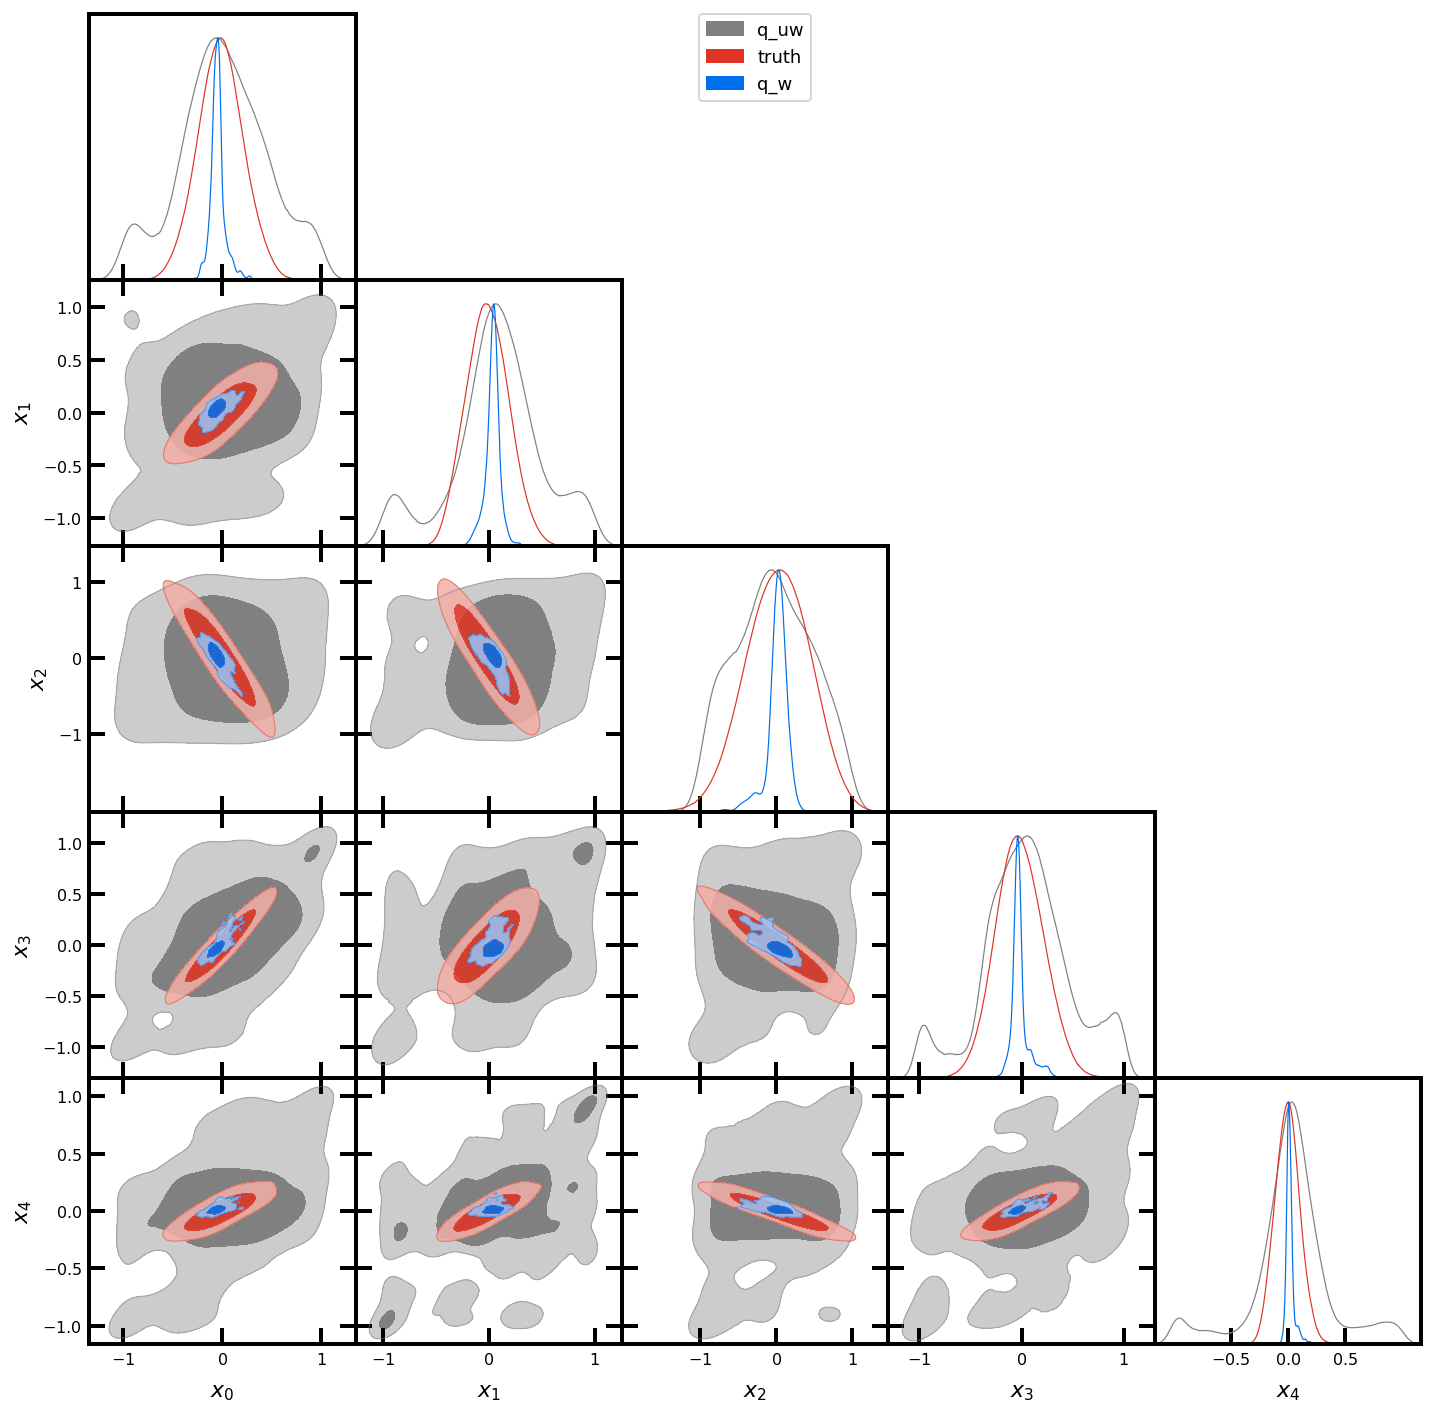

Removed no burn in
Removed no burn in
Removed no burn in


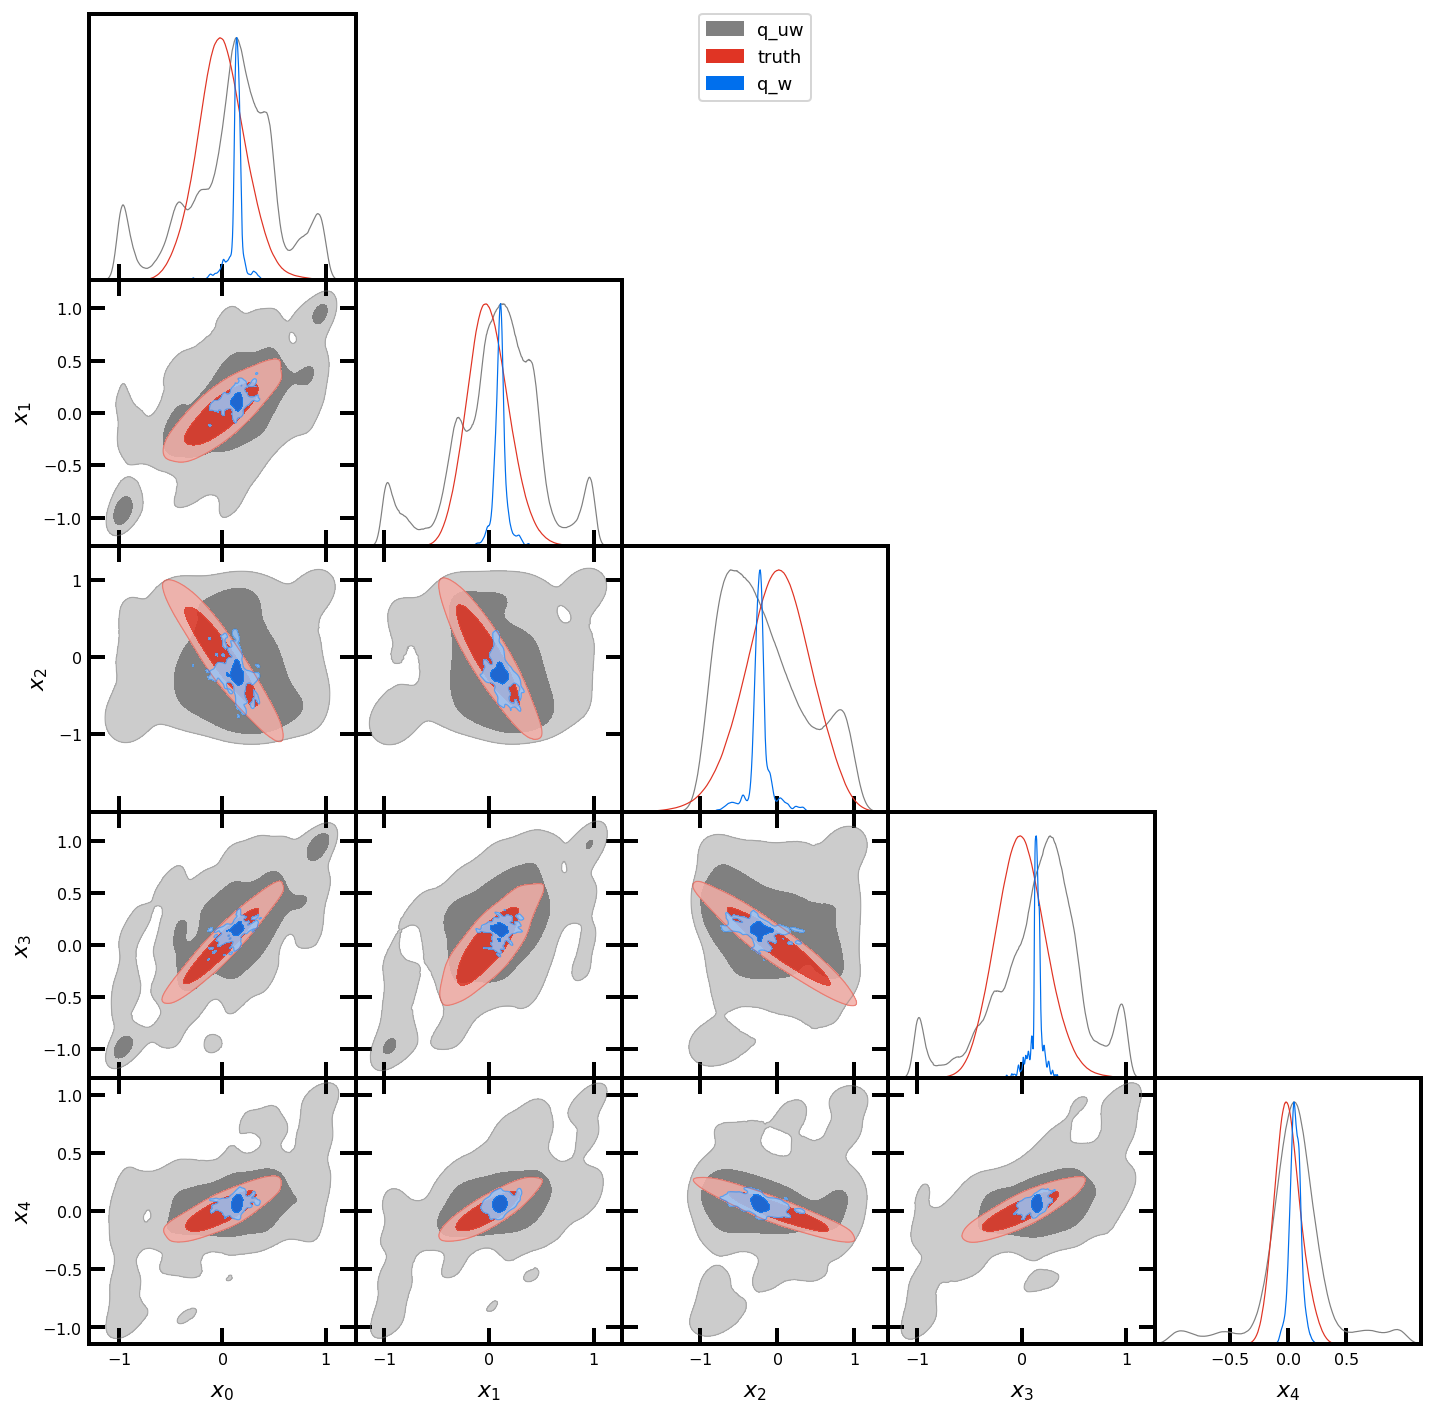

Removed no burn in
Removed no burn in
Removed no burn in


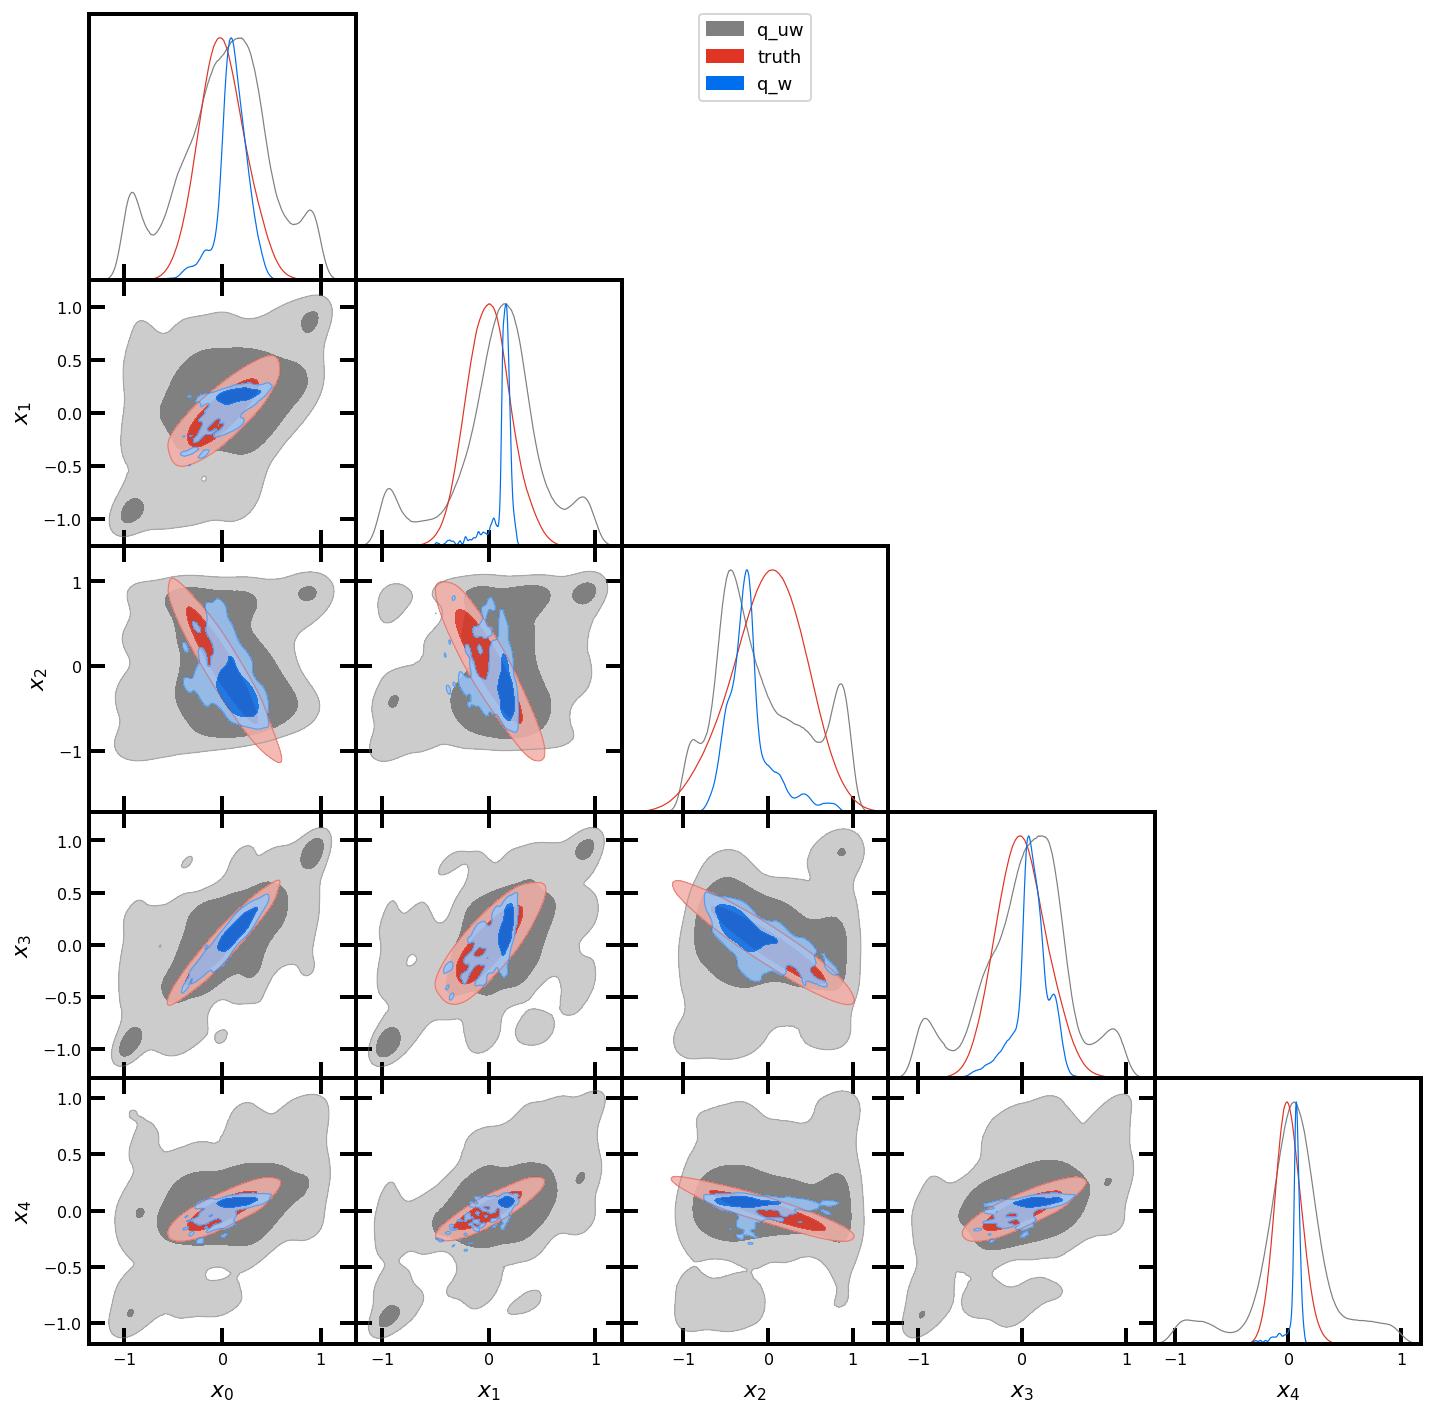

In [20]:
for t in vg: plot_corr_gd(t,Cov)

$\beta=1$

beta=1.105 at level 23 out of 26 levels
Removed no burn in
Removed no burn in
Removed no burn in


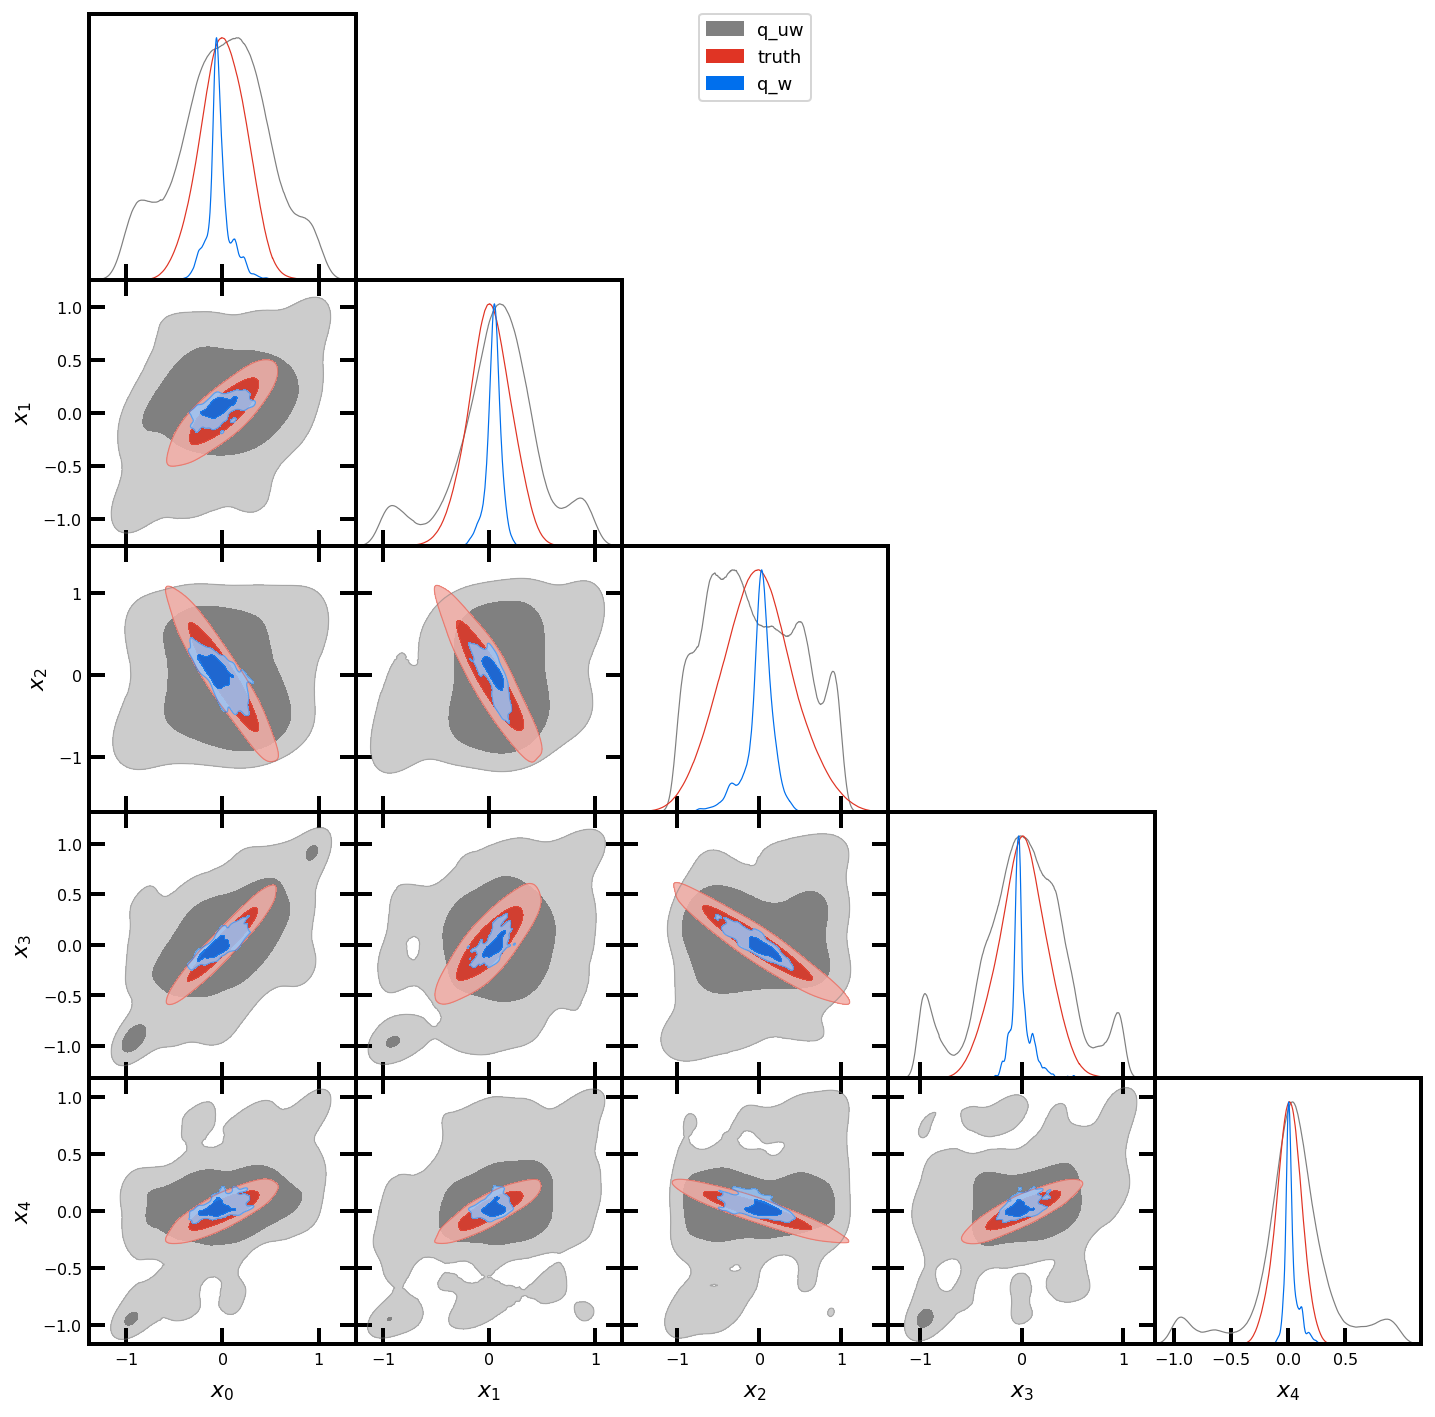

beta=1.026 at level 39 out of 45 levels
Removed no burn in
Removed no burn in
Removed no burn in


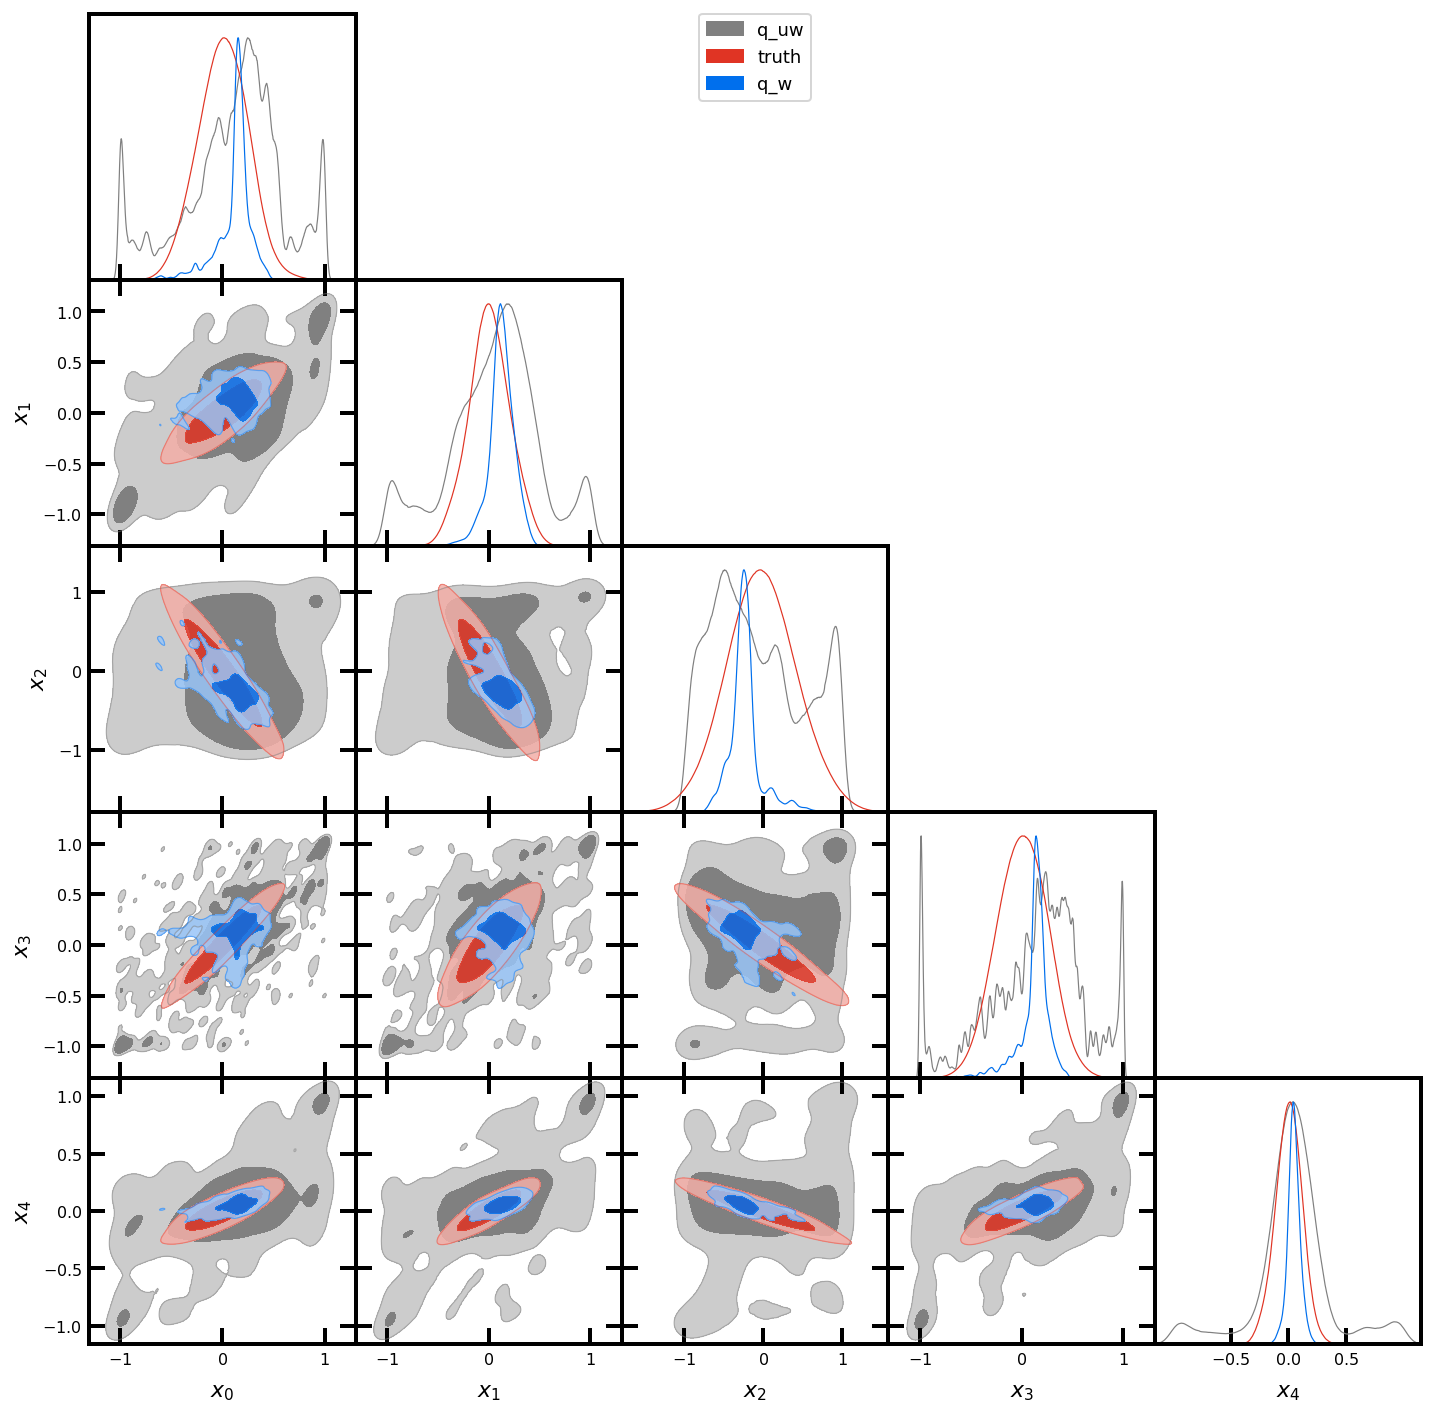

beta=0.965 at level 23 out of 29 levels
Removed no burn in
Removed no burn in
Removed no burn in


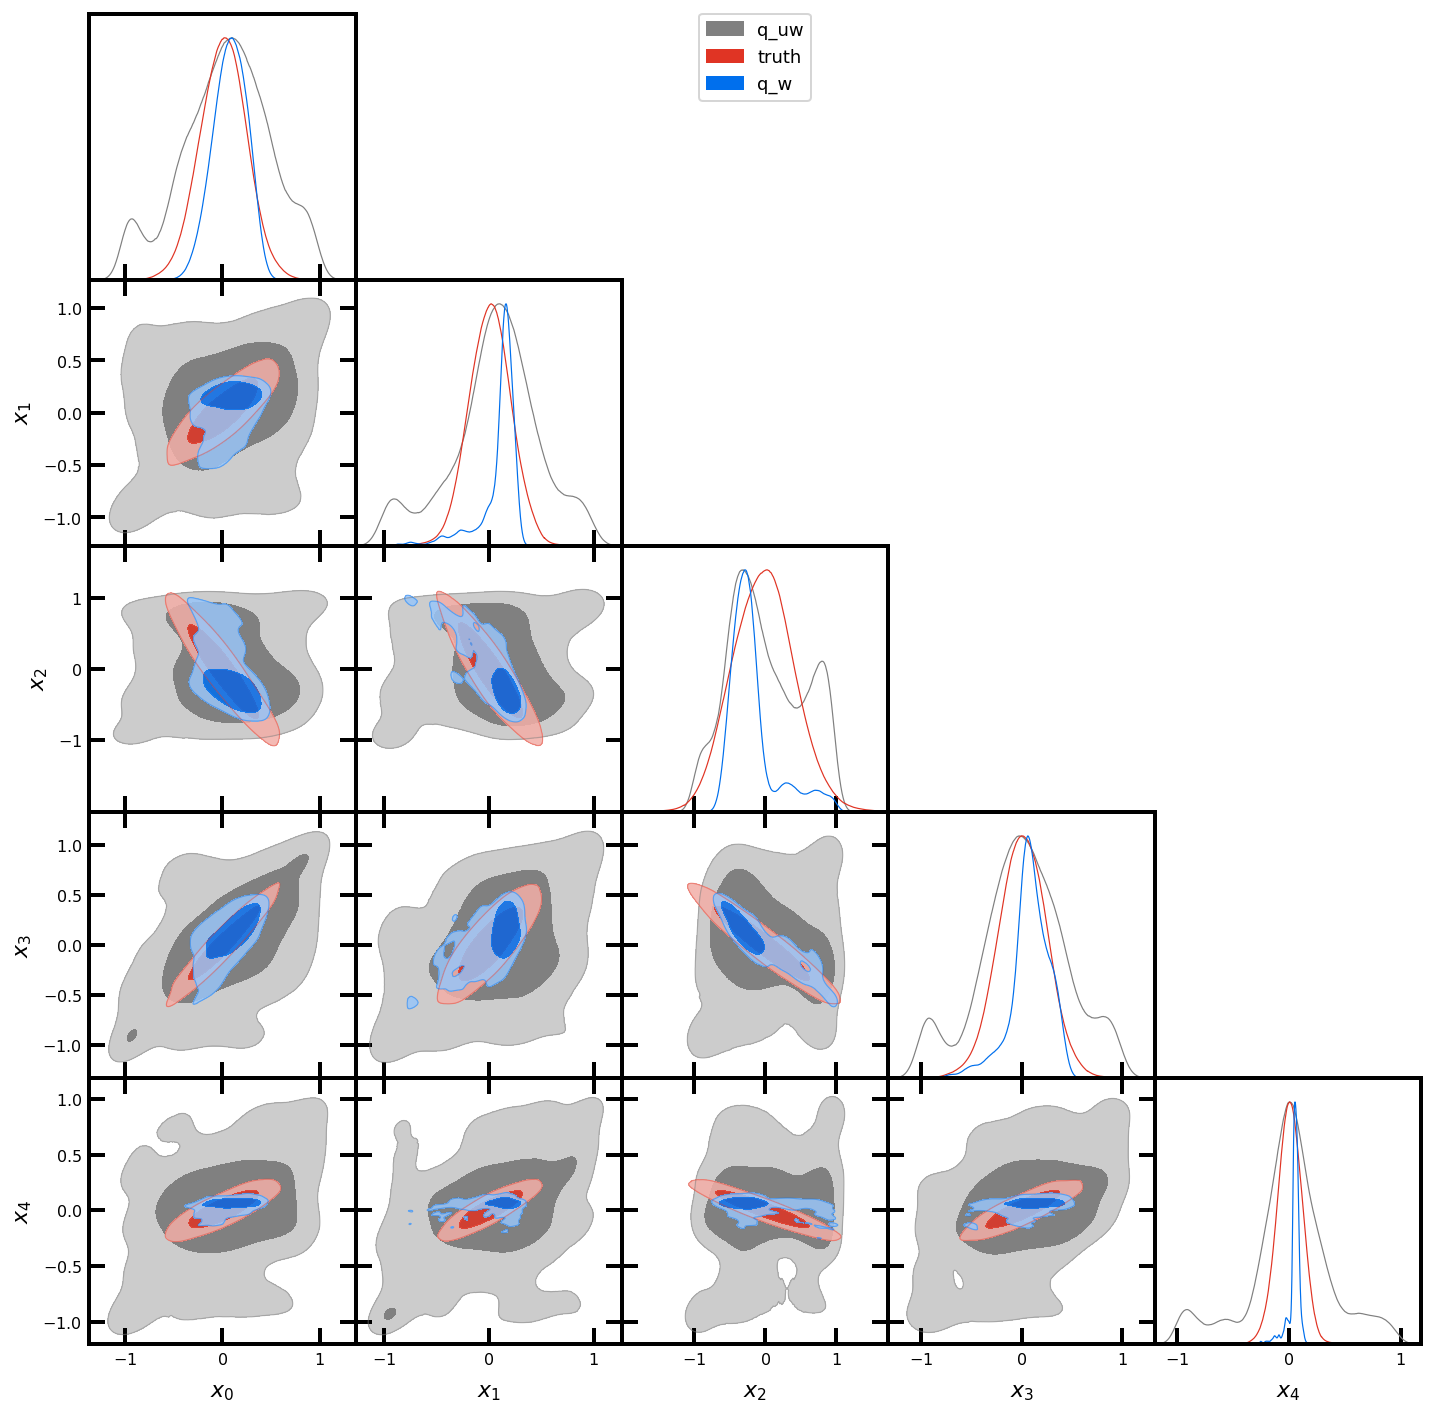

In [21]:
for t in vg:
    beta1idx=np.argmin(np.abs(np.array(t['betas'][0])*1.5-1))
    print('beta={0:.3f} at level {1} out of {2} levels'.format(t['betas'][0][beta1idx]*1.5,beta1idx,len(t['betas'][0])))
    plot_corr_gd(t,Cov,beta_idx=beta1idx)

### Alternative Loss (for later)

In [ ]:
# the thing mentioned in slack

## $Z_{w}, Z_{uw}$ output

In [15]:
cg5 = run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False)

Inference mode is optimization. Maximum beta is: 1.5


In [53]:
Zuws = np.exp(np.array([cg5['logZ'][0]['q{0}_pq_uw'.format(i)] for i in range(1,len(cg5['betas'][0]))]))
Zws = np.exp(np.array([cg5['logZ'][0]['q{0}_pq_w'.format(i)] for i in range(1,len(cg5['betas'][0]))]))
Zts = np.array([cg5['logZ'][0]['q{0}_pq_w_trainable'.format(i)] for i in range(1,len(cg5['betas'][0]))])

In [56]:
Zts

array([3.46741825e-01, 3.52313936e-01, 3.18607092e-01, 1.75871387e-01,
       6.46652505e-02, 3.29475924e-02, 2.17325184e-02, 1.15038212e-02,
       3.41048092e-03, 3.40630068e-03, 6.62535429e-03, 8.65174085e-03,
       3.74202617e-03, 2.55929772e-03, 8.39691784e-04, 1.11580873e-03,
       6.29050948e-04, 2.72203004e-04, 1.92288120e-04, 2.46673496e-03,
       1.42528862e-03, 9.08381422e-04, 1.93136383e-03, 3.19497734e-02,
       6.10696599e-02, 3.31945300e-01])

Not exactly sure what is happening here...

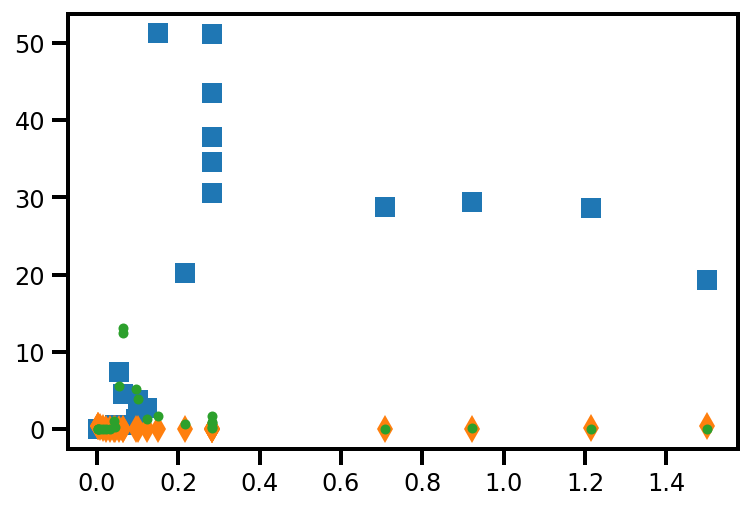

In [59]:
plt.plot(np.array(cg5['betas'][0][1:])*1.5,Zuws,ls=' ',marker='s')
plt.plot(np.array(cg5['betas'][0][1:])*1.5,Zts,ls=' ',marker='d')

plt.plot(np.array(cg5['betas'][0][1:])*1.5,Zws,ls=' ',marker='.')


## Varying $Y$
### $Y = \{0.5, 1, 2\}$
Best -> Y=1, Y=2 is biased

In [25]:
ys,vy = [0.5,1.,2.],[]
for y in ys: vy.append(run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,frac_rel_beta_AF=y))

Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5


Removed no burn in
Removed no burn in
Removed no burn in


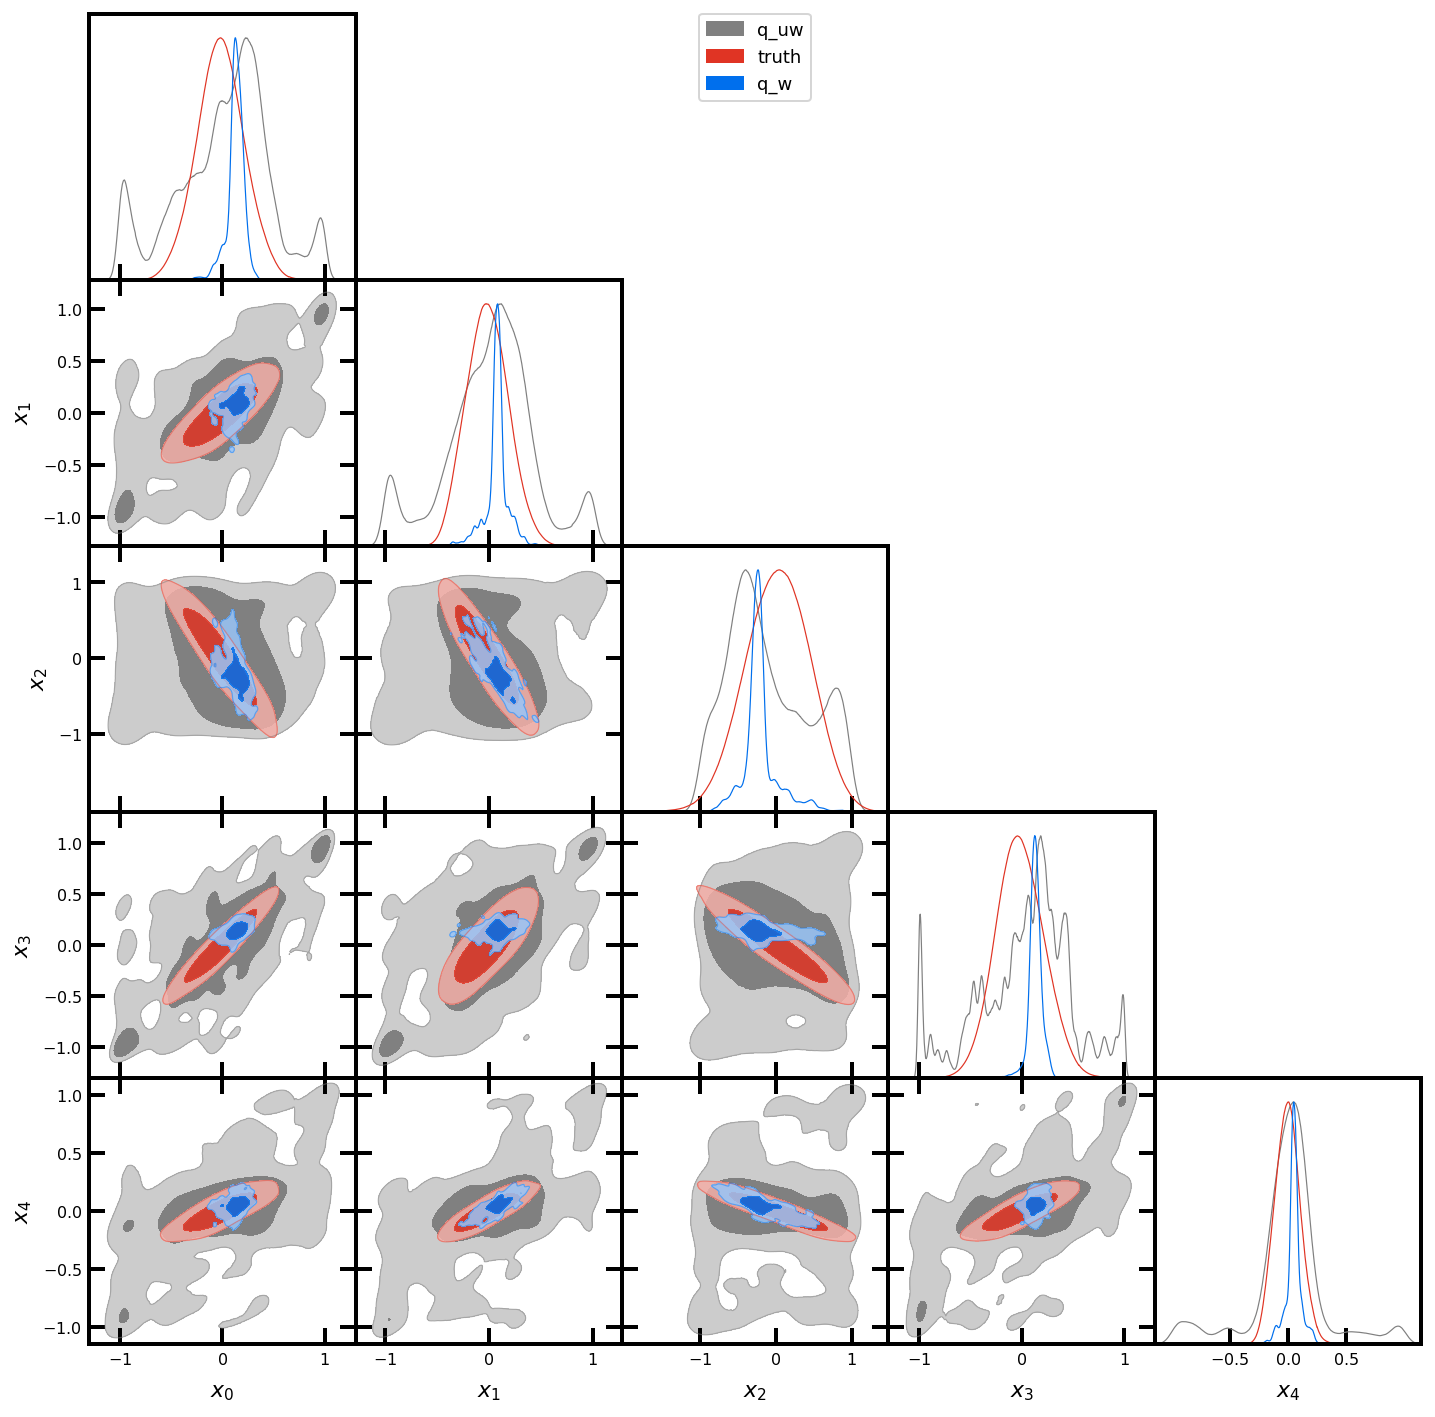

Removed no burn in
Removed no burn in
Removed no burn in


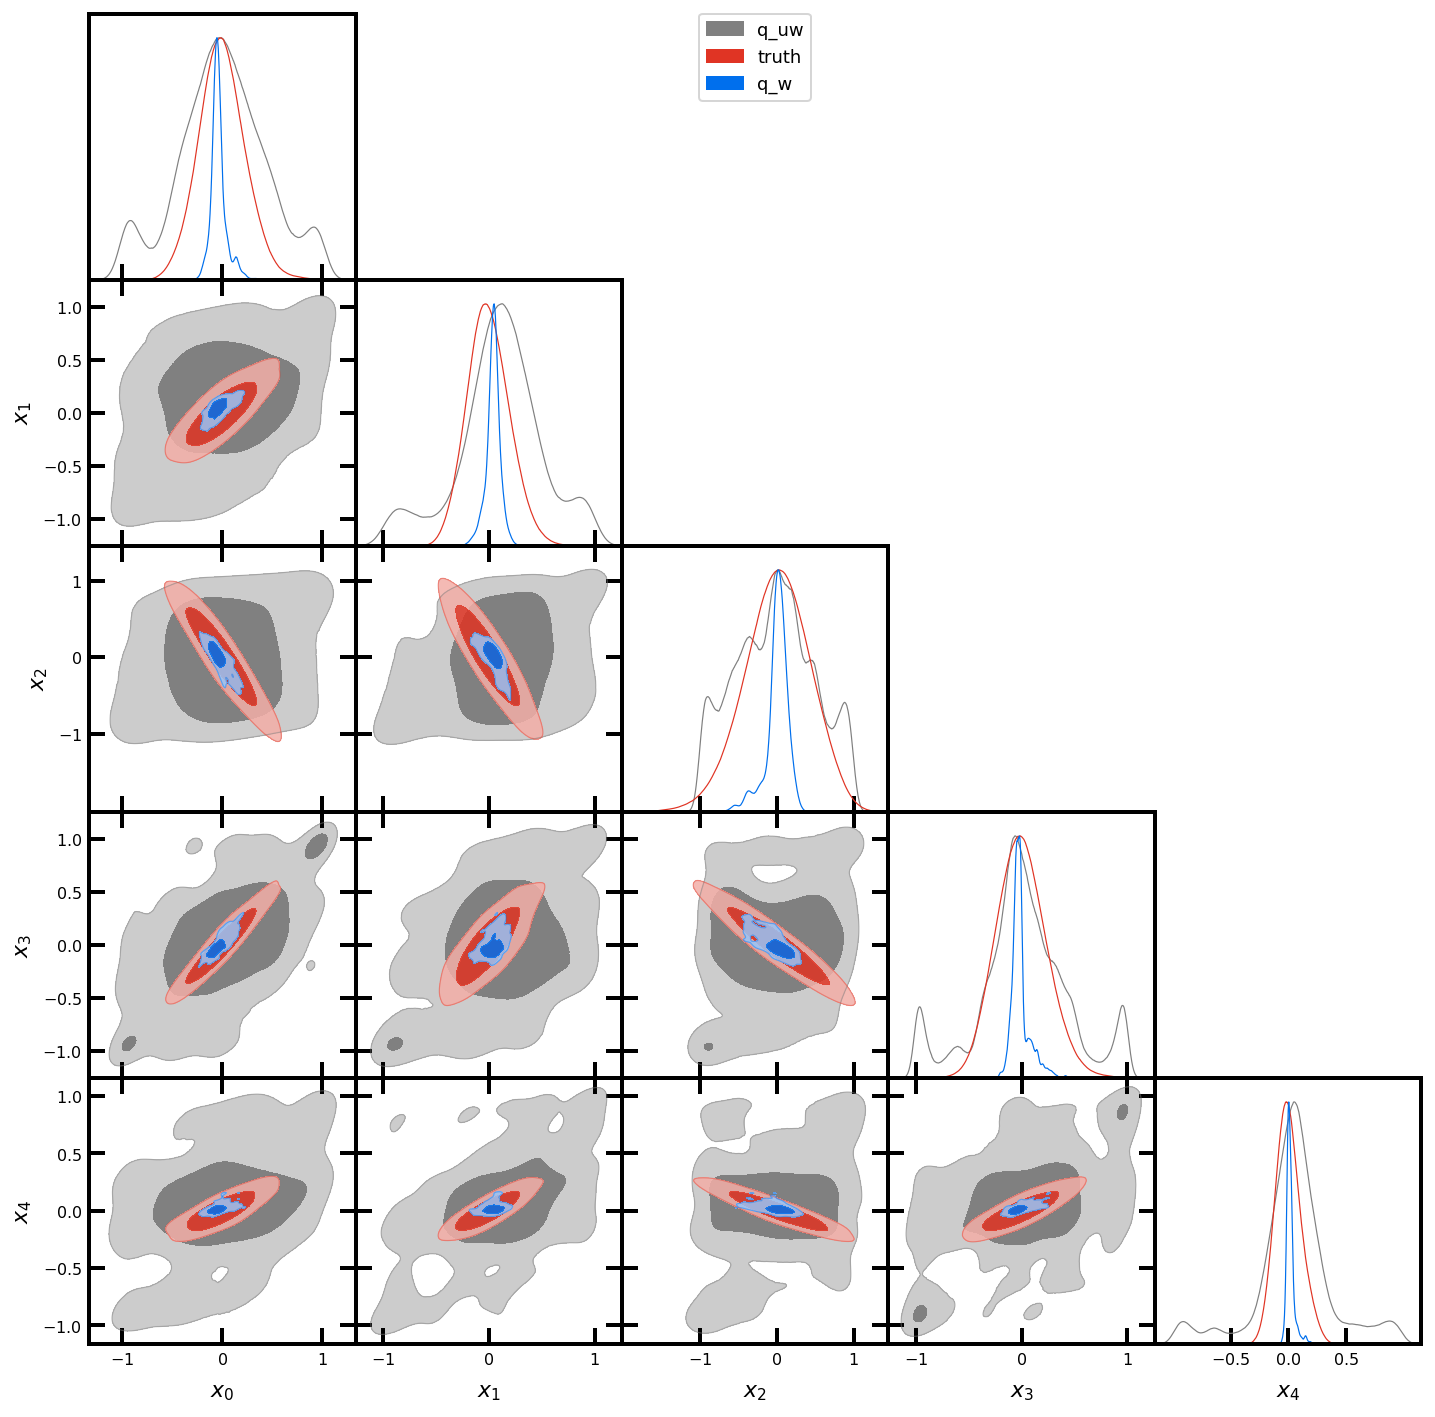

Removed no burn in
Removed no burn in
Removed no burn in


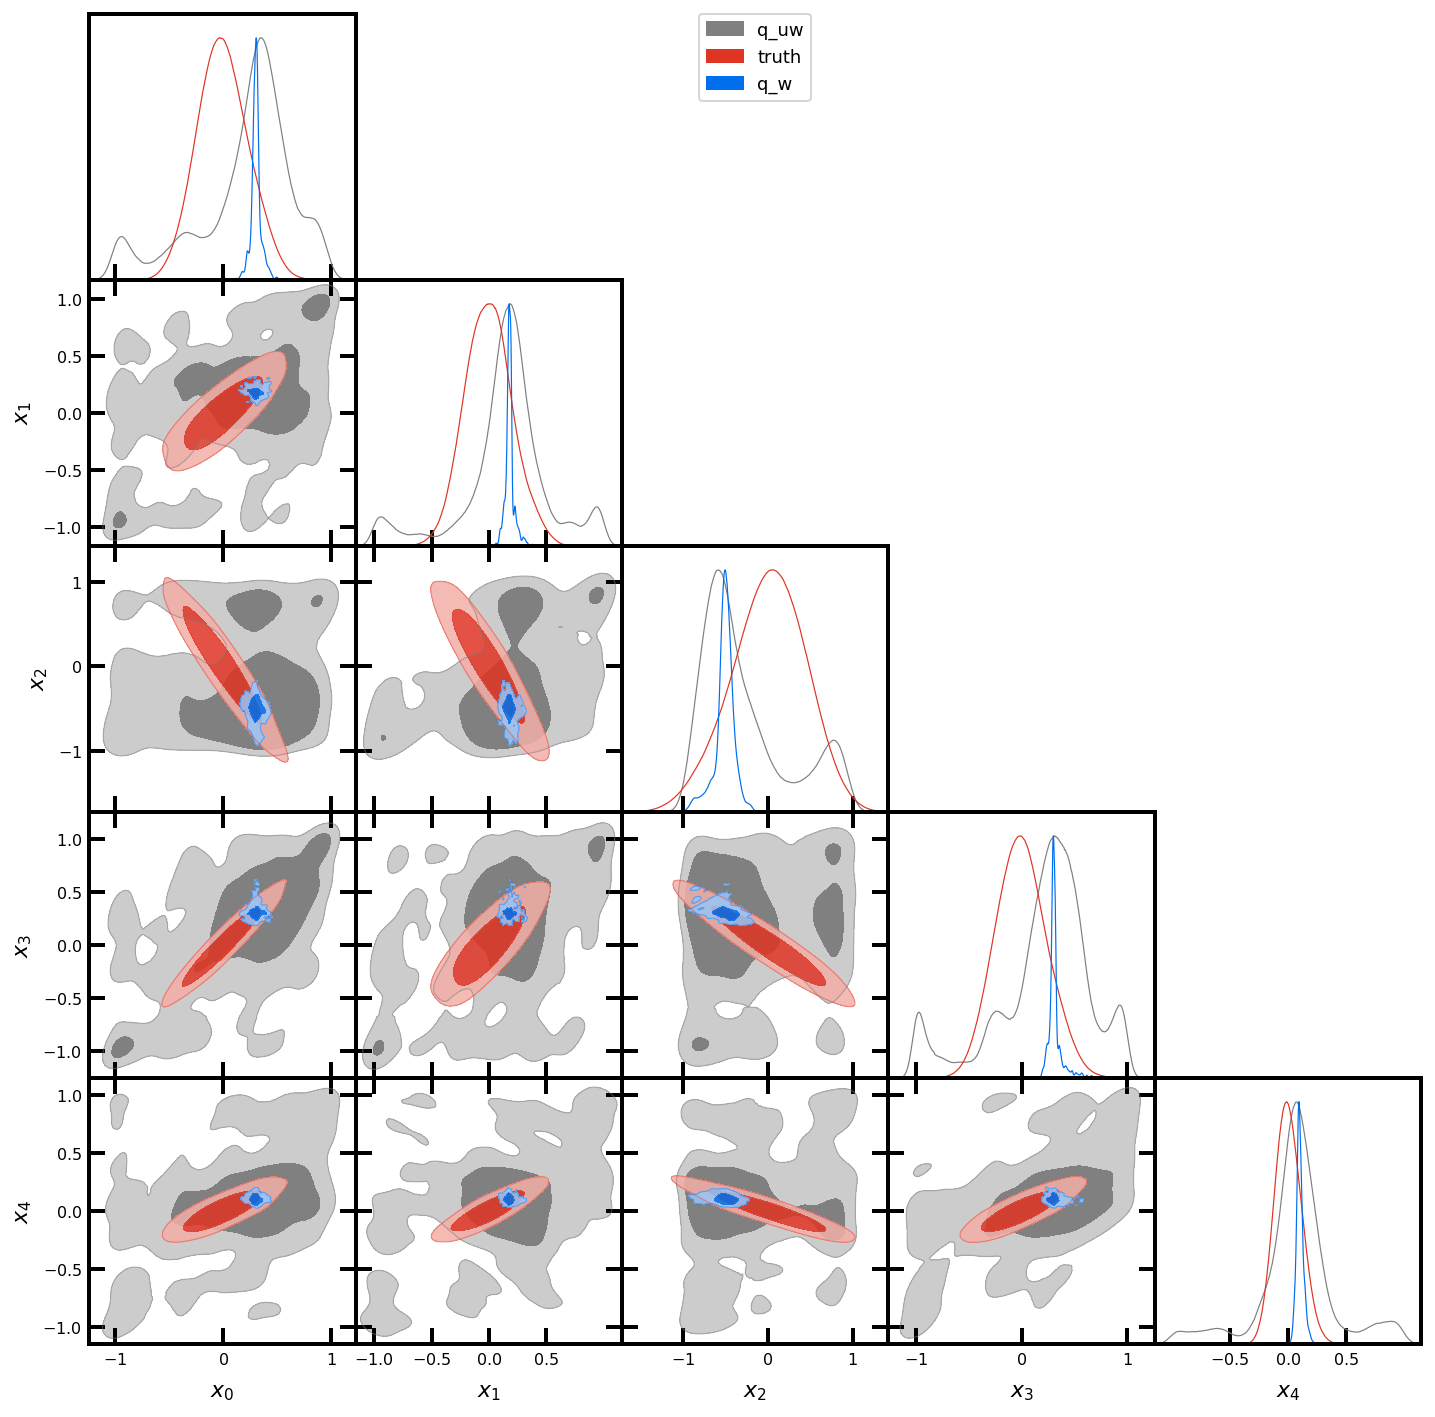

In [26]:
for t in vy: plot_corr_gd(t,Cov)

## Varying exploration strategies
### Fiducial: top_AF=n, expl_latent=n, expl_top_qw=n

### top_AF=$\{0, n, 2n\}$

In [27]:
bs,vb = [0,1,2],[]
for b in bs: vb.append(run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,b=b))

Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5


Removed no burn in
Removed no burn in
Removed no burn in


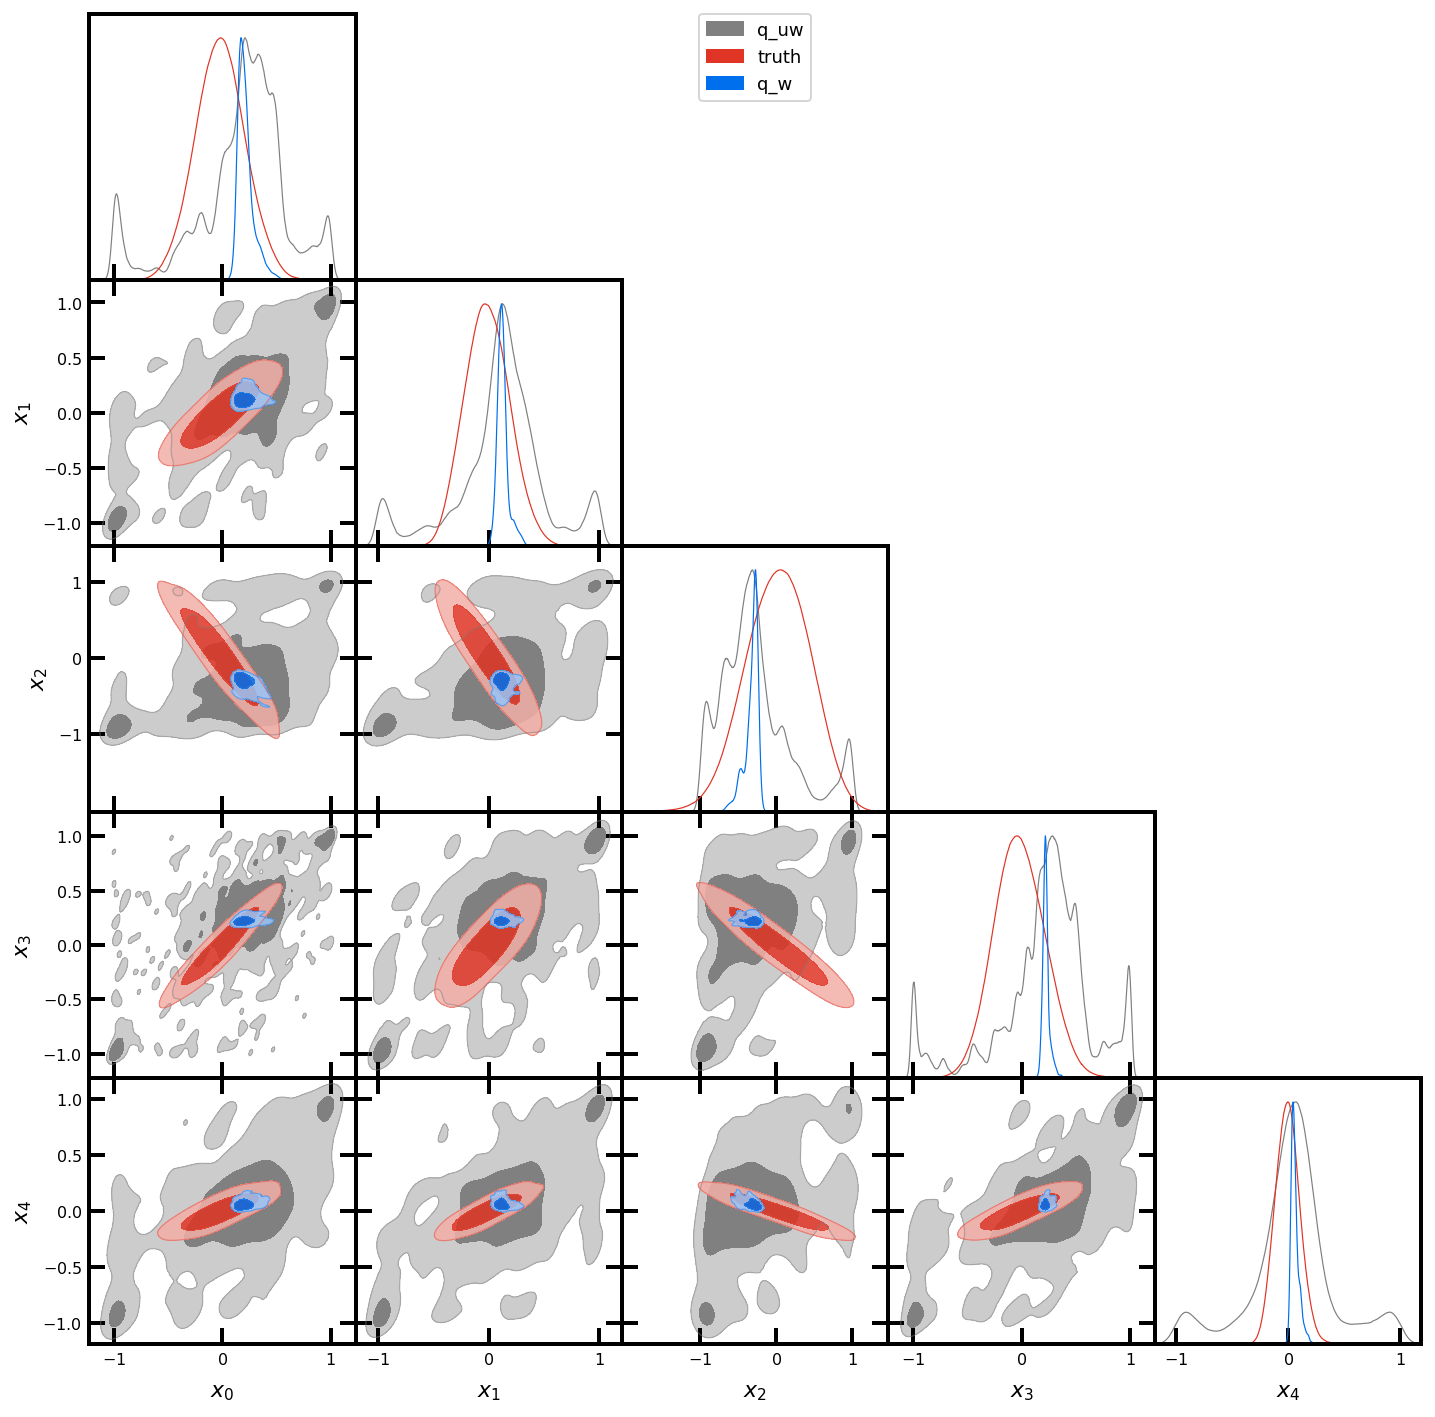

Removed no burn in
Removed no burn in
Removed no burn in


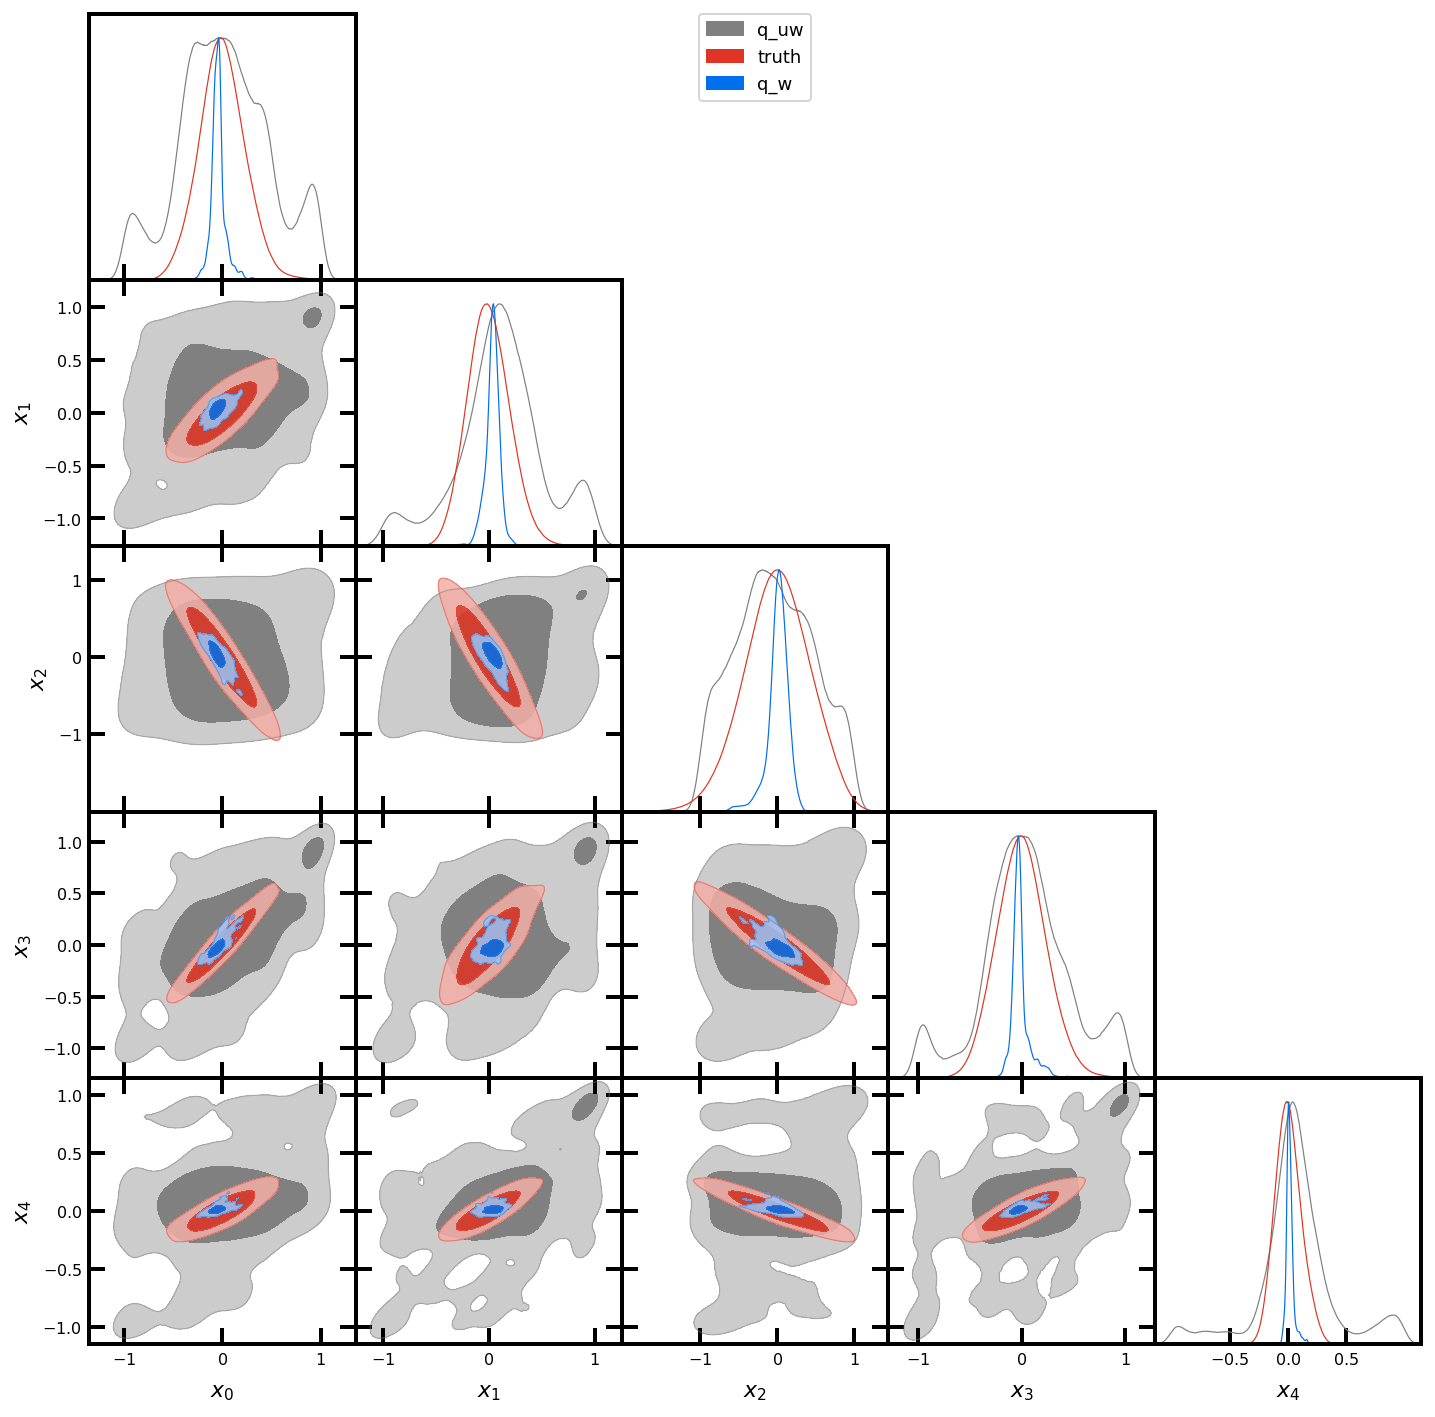

Removed no burn in
Removed no burn in
Removed no burn in


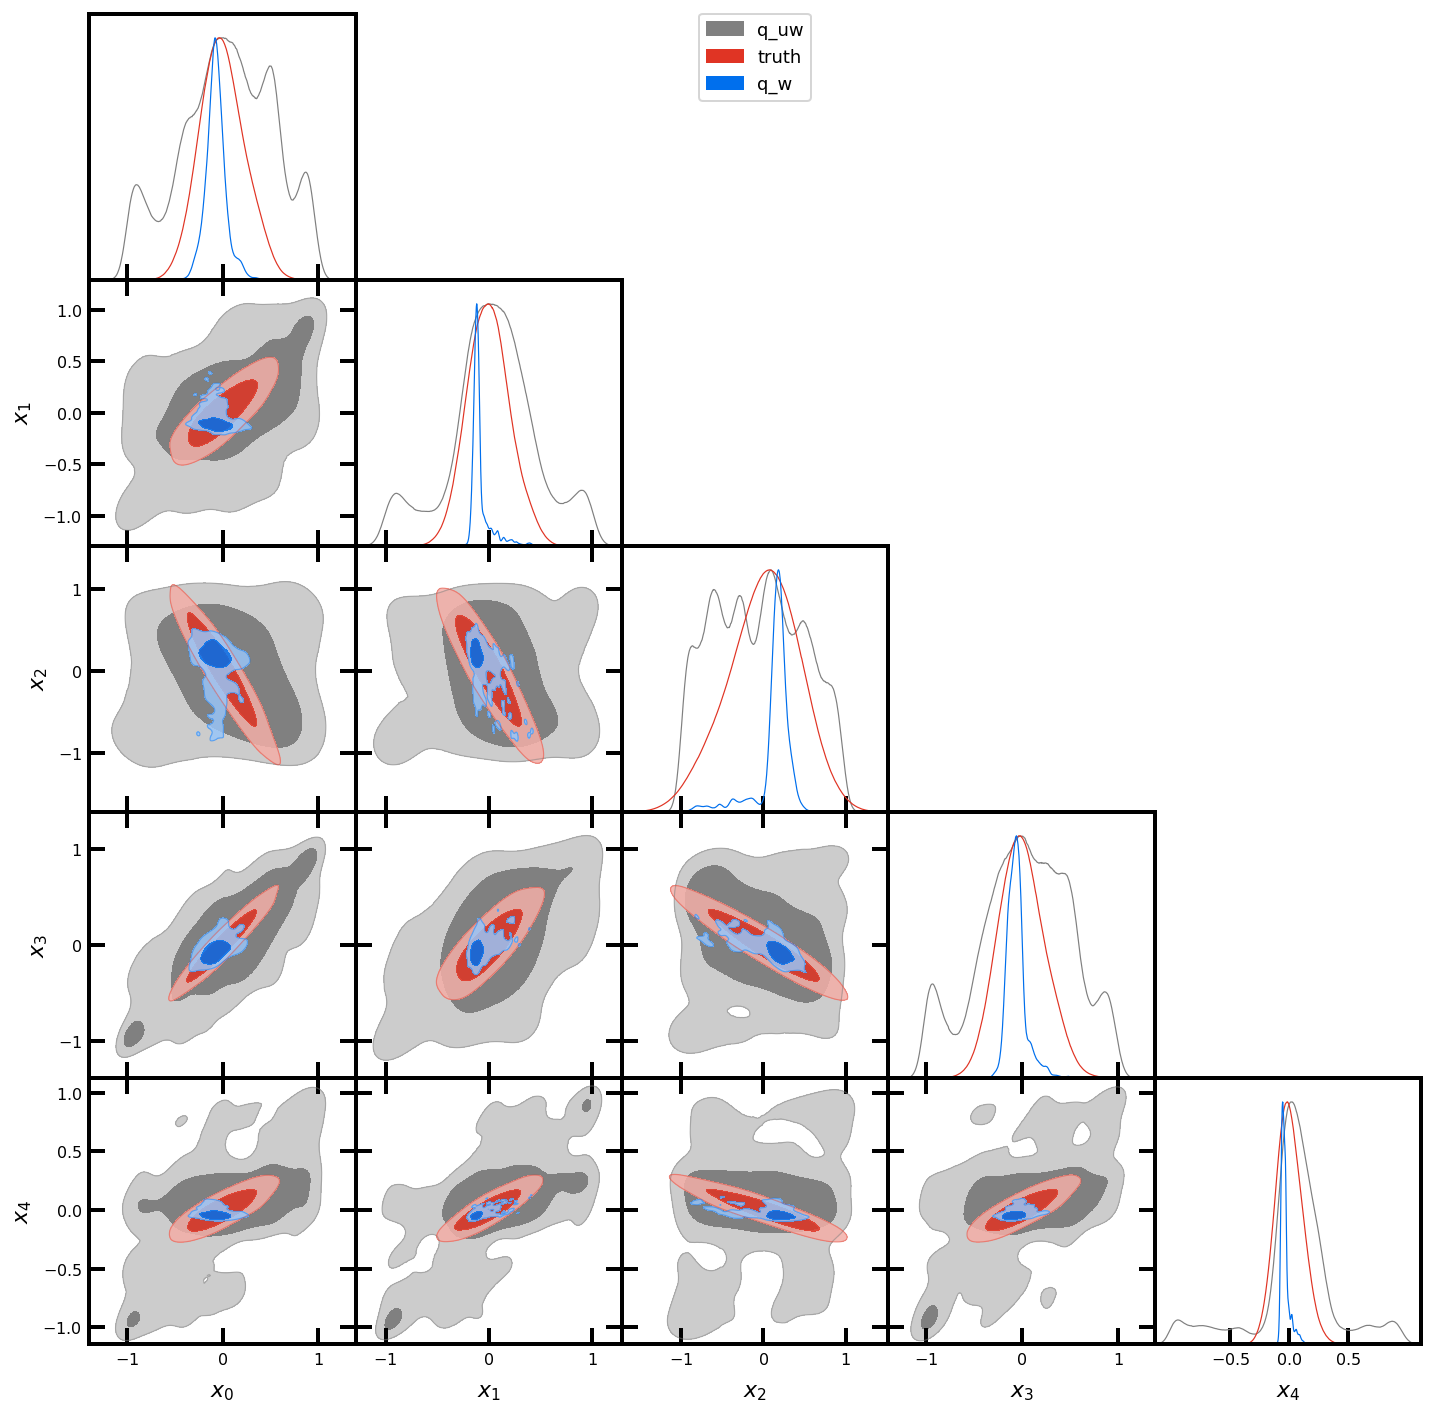

In [28]:
for t in vb: plot_corr_gd(t,Cov)

### expl_latent=$\{0, n, 2n\}$

In [ ]:
cs,vc = [0,1,2],[]
for c in cs: vc.append(run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=True,c=c))

Removed no burn in
Removed no burn in
Removed no burn in


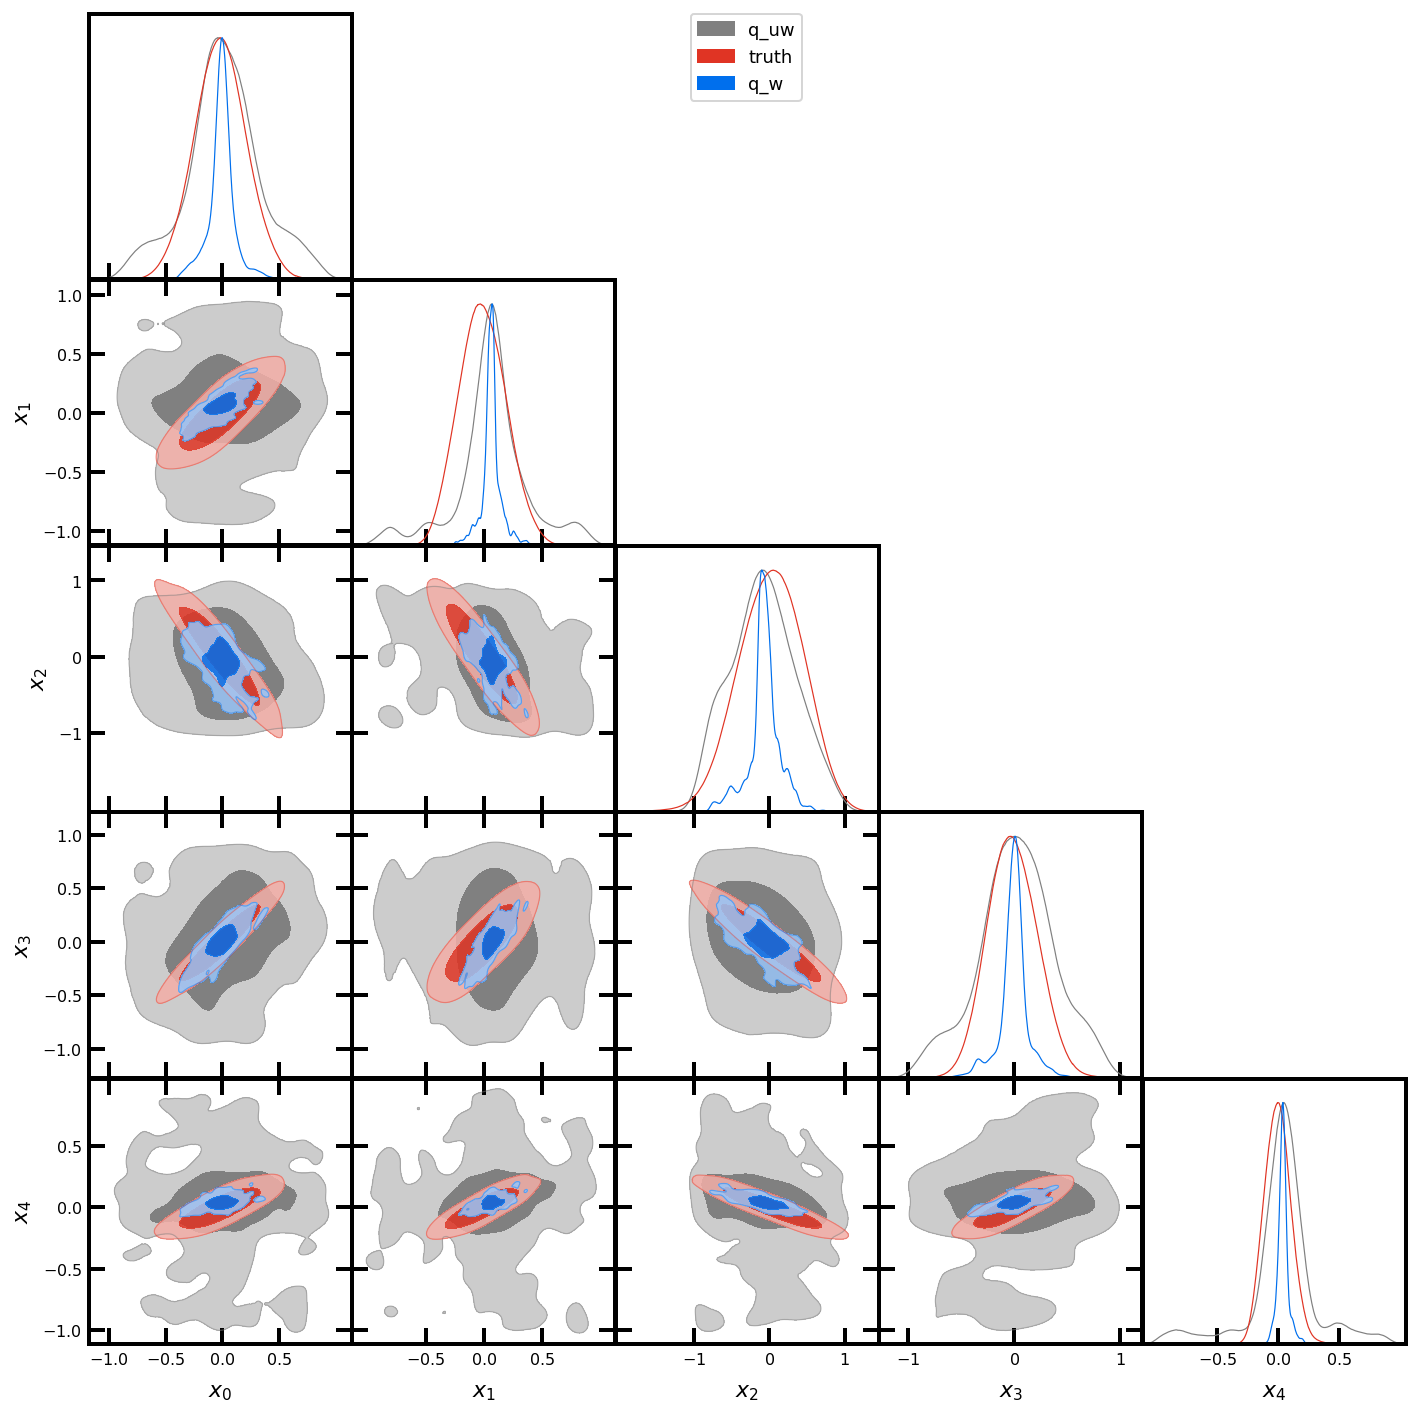

Removed no burn in
Removed no burn in
Removed no burn in


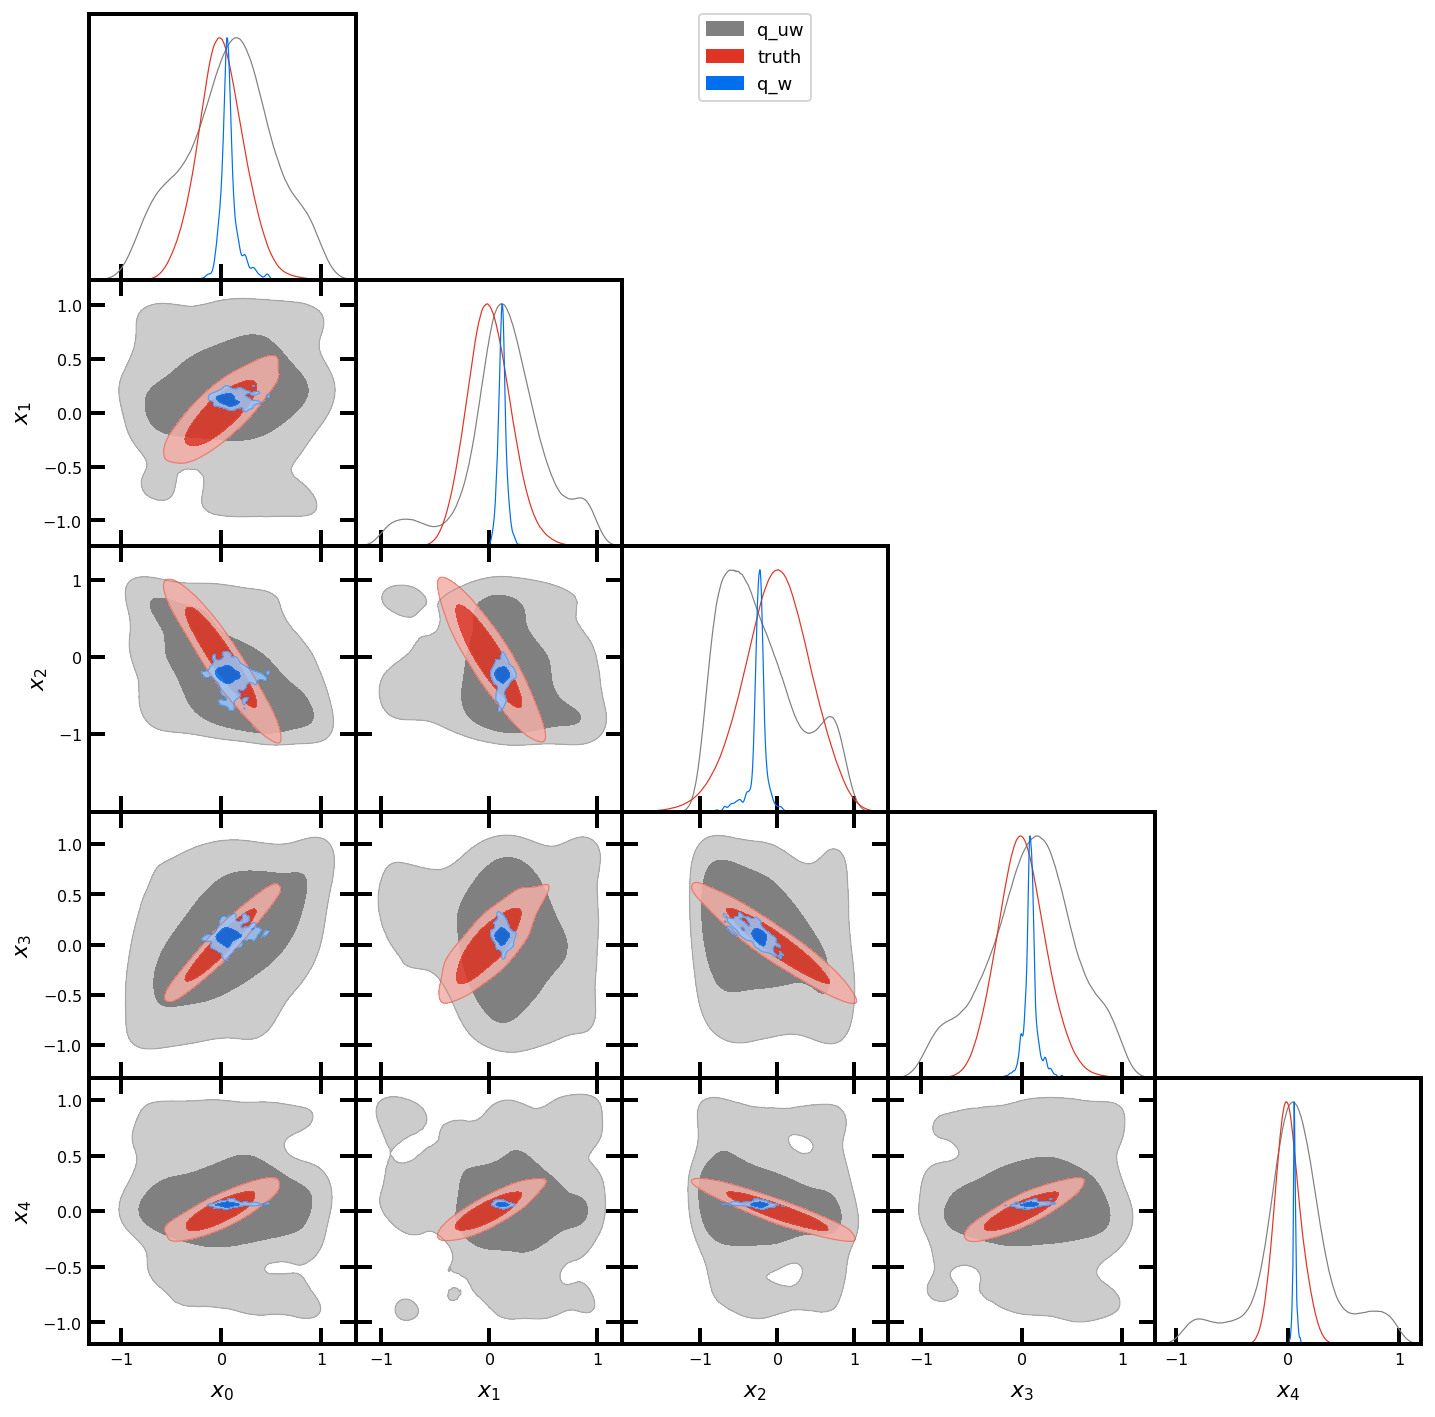

Removed no burn in
Removed no burn in
Removed no burn in


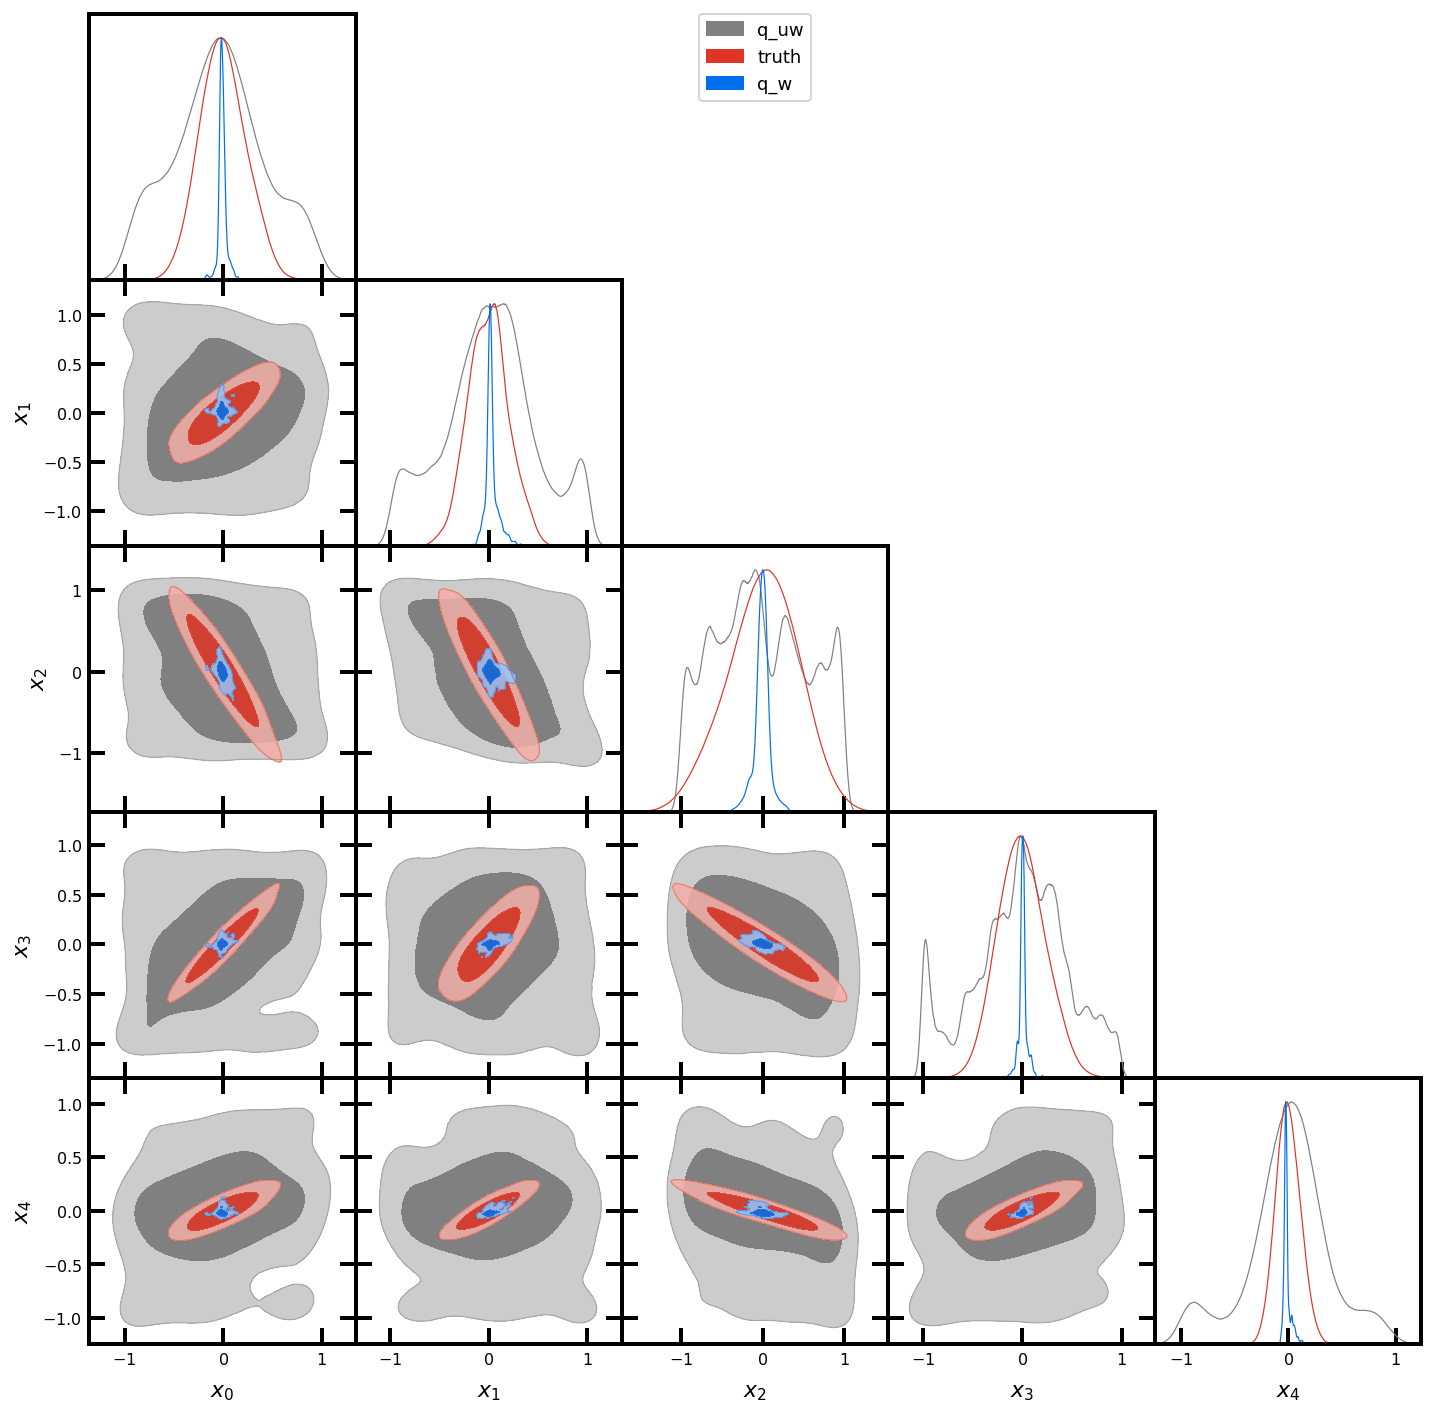

In [9]:
for t in vc: plot_corr_gd(t,Cov)

### expl_top_qw=$\{0, n, 2n\}$

In [ ]:
ds,vd = [0,1,2],[]
for d in ds: vd.append(run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,d=d))

Removed no burn in
Removed no burn in
Removed no burn in


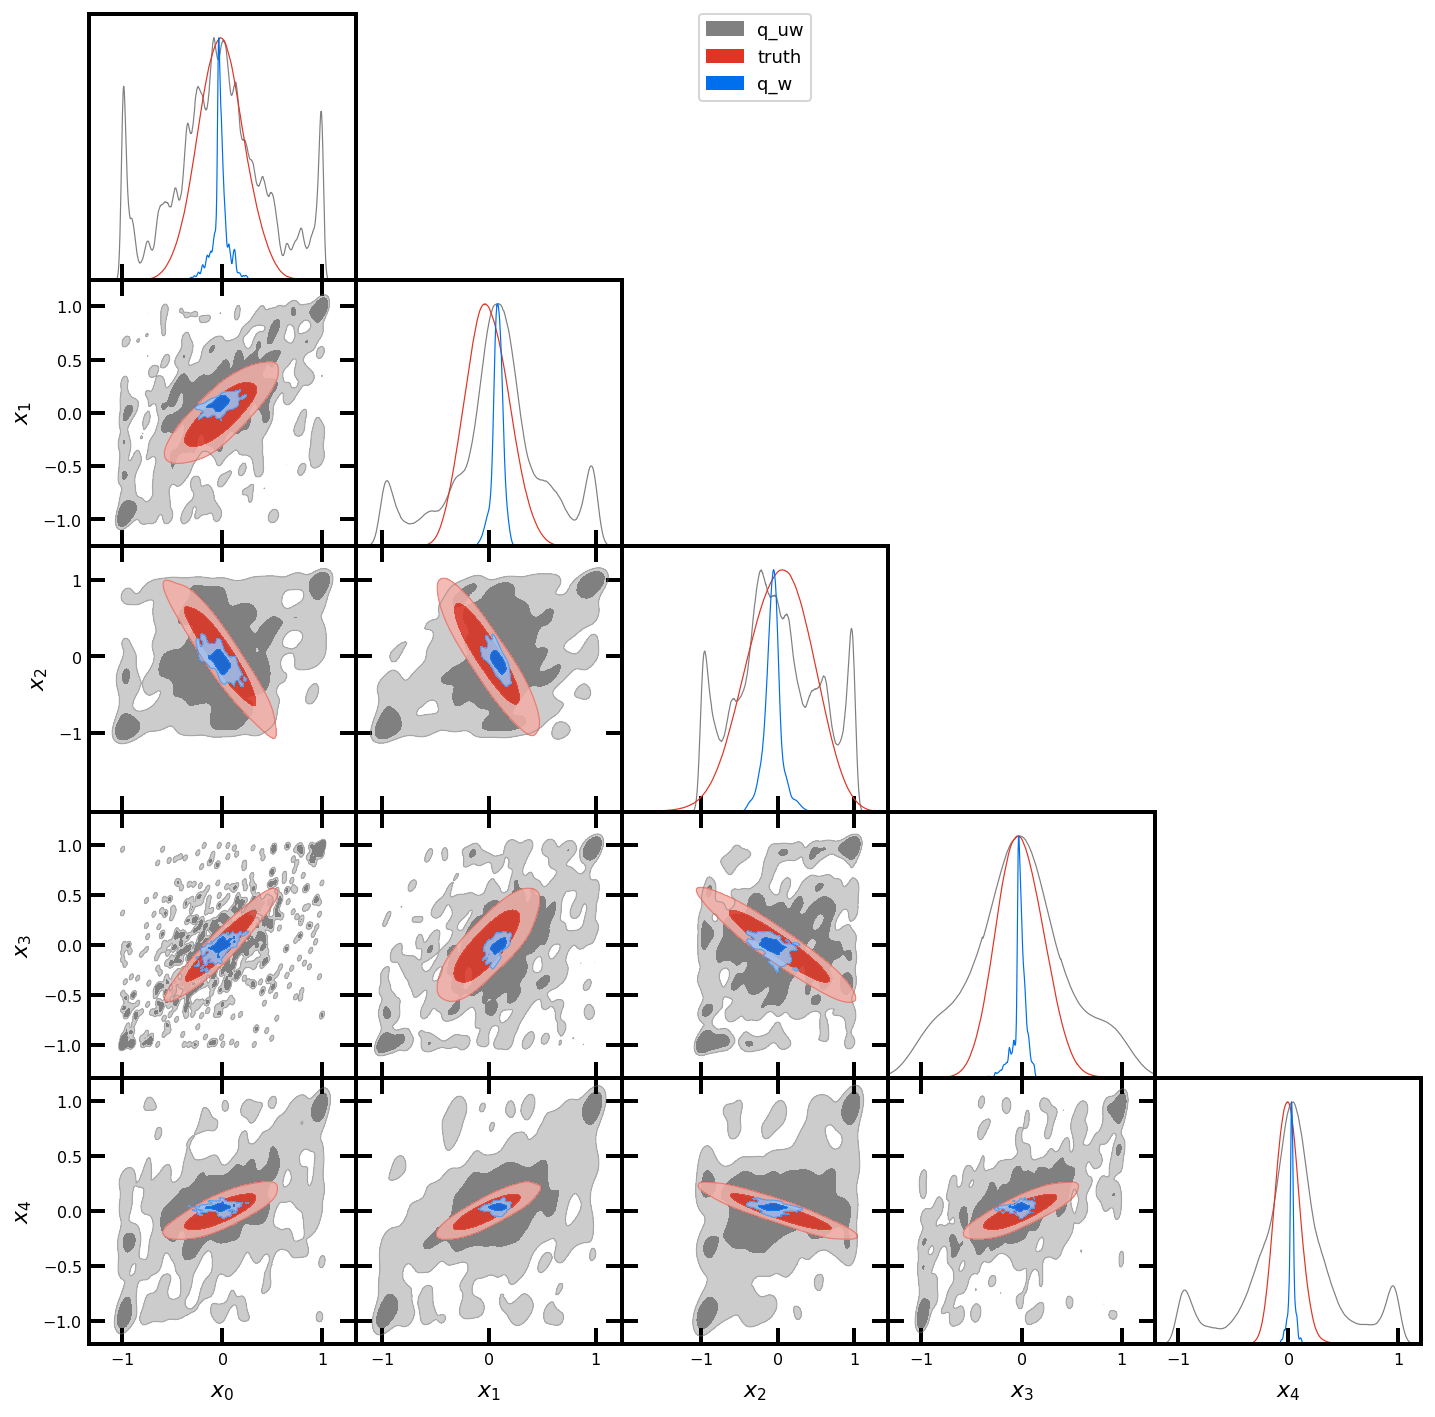

Removed no burn in
Removed no burn in
Removed no burn in


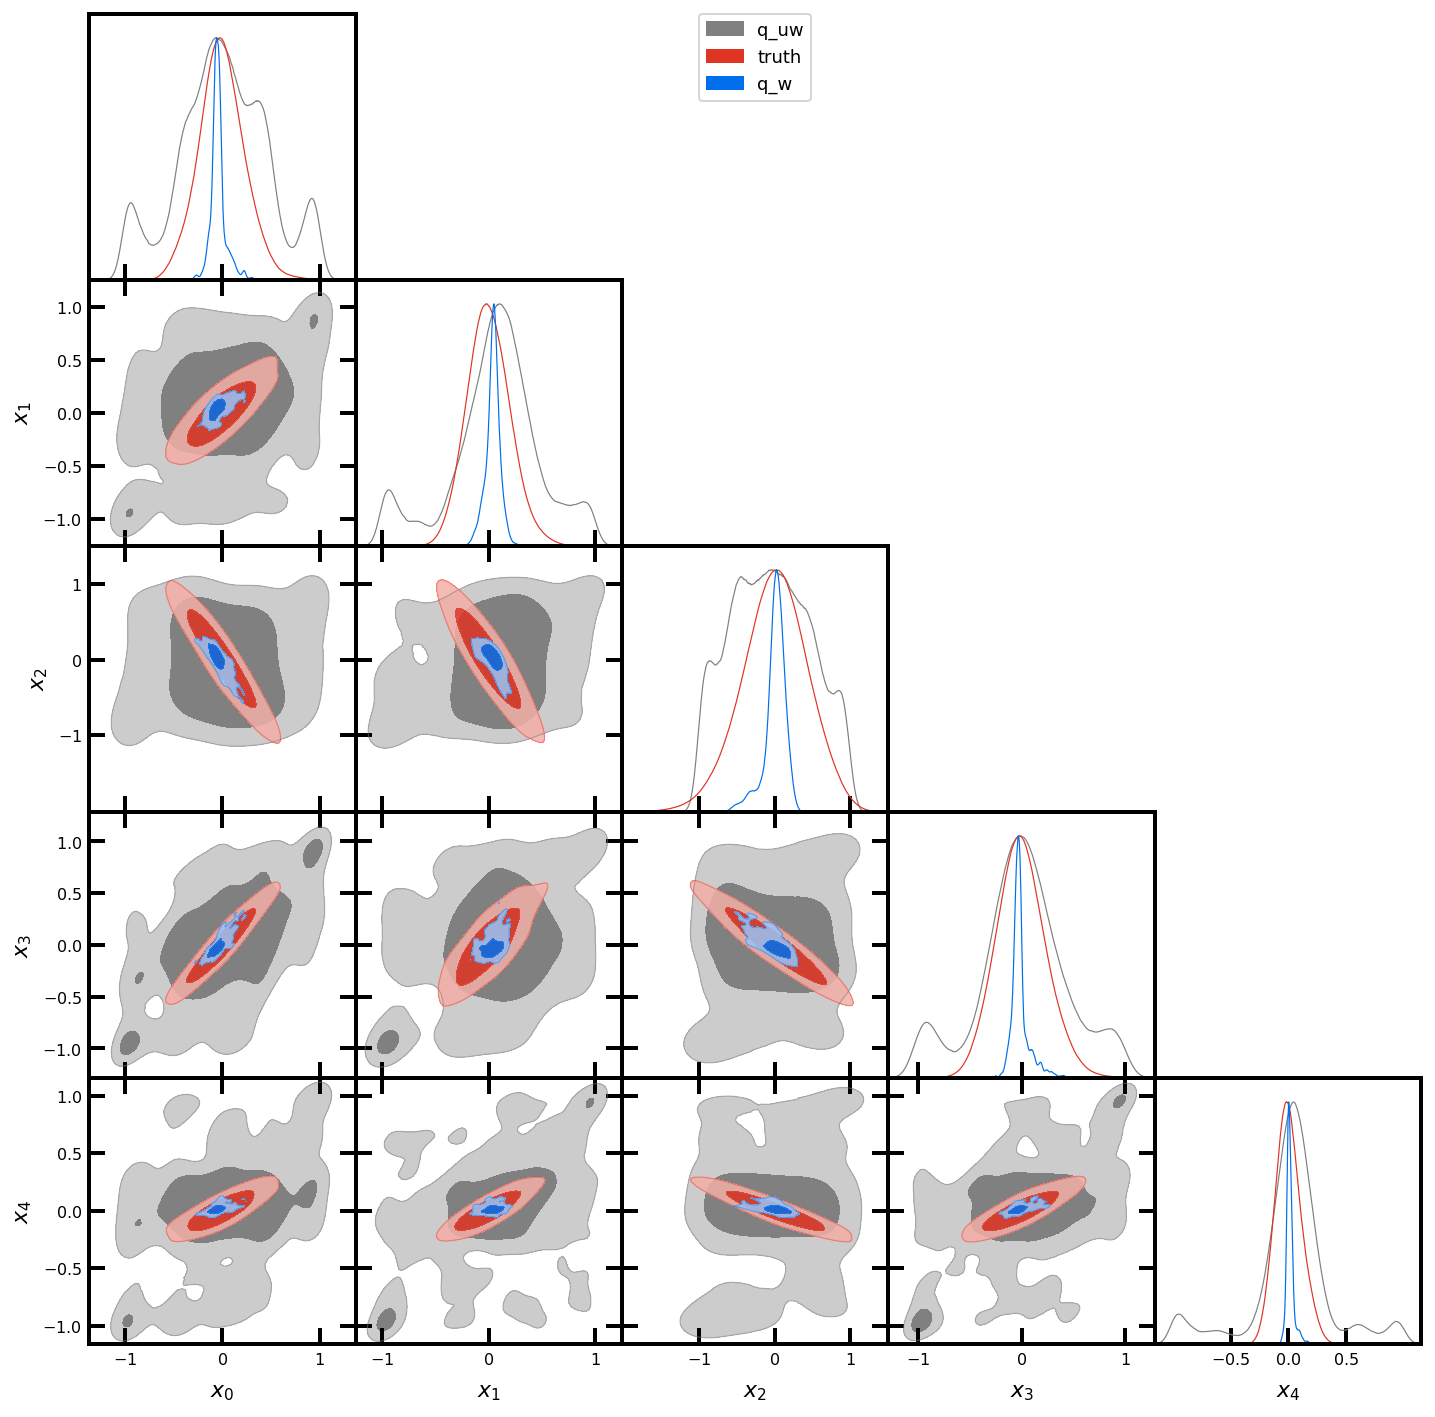

Removed no burn in
Removed no burn in
Removed no burn in


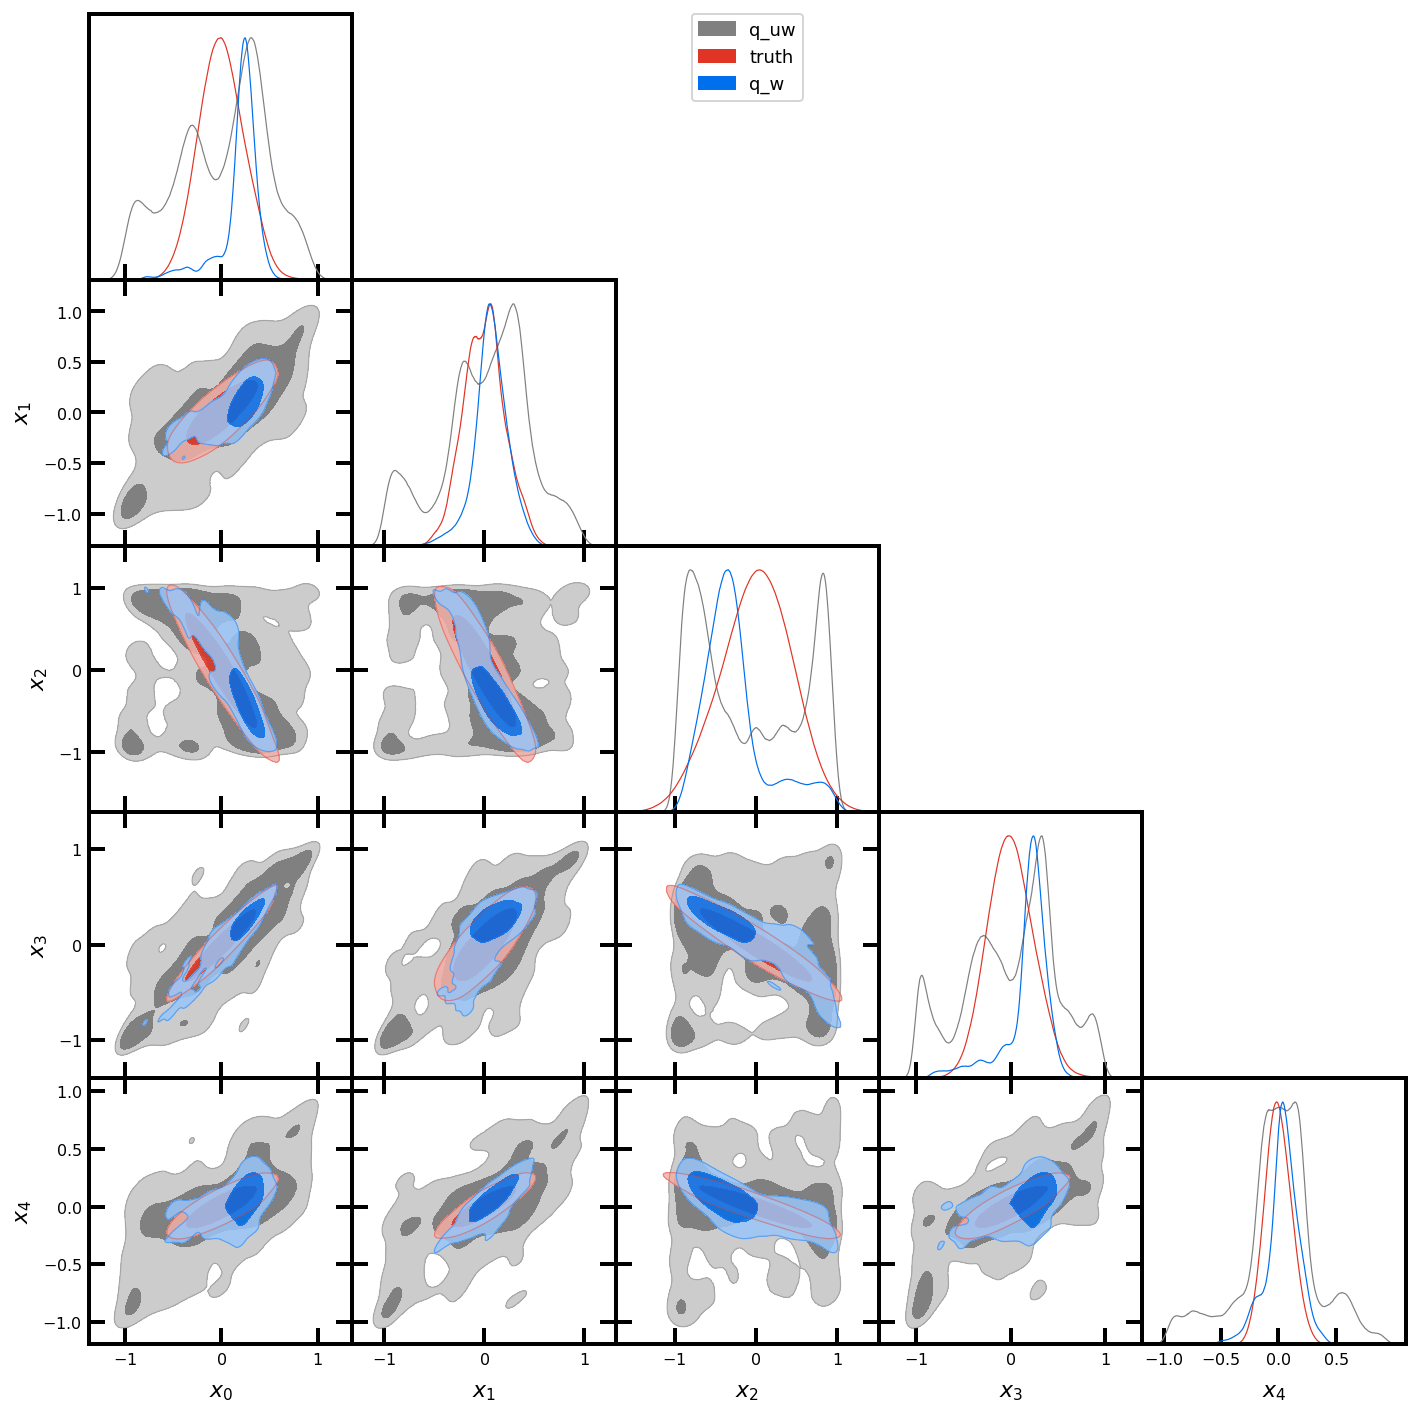

In [9]:
for t in vd: plot_corr_gd(t,Cov)

## Changing fixed ESS criterion
Higher better on bias

$\rm{ESS} = \{0.7 ,.8, .9\}$

In [62]:
es,ve = [.7,.8,.9],[]
for e in es: ve.append(run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,t_ess=e))

Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5


Removed no burn in
Removed no burn in
Removed no burn in


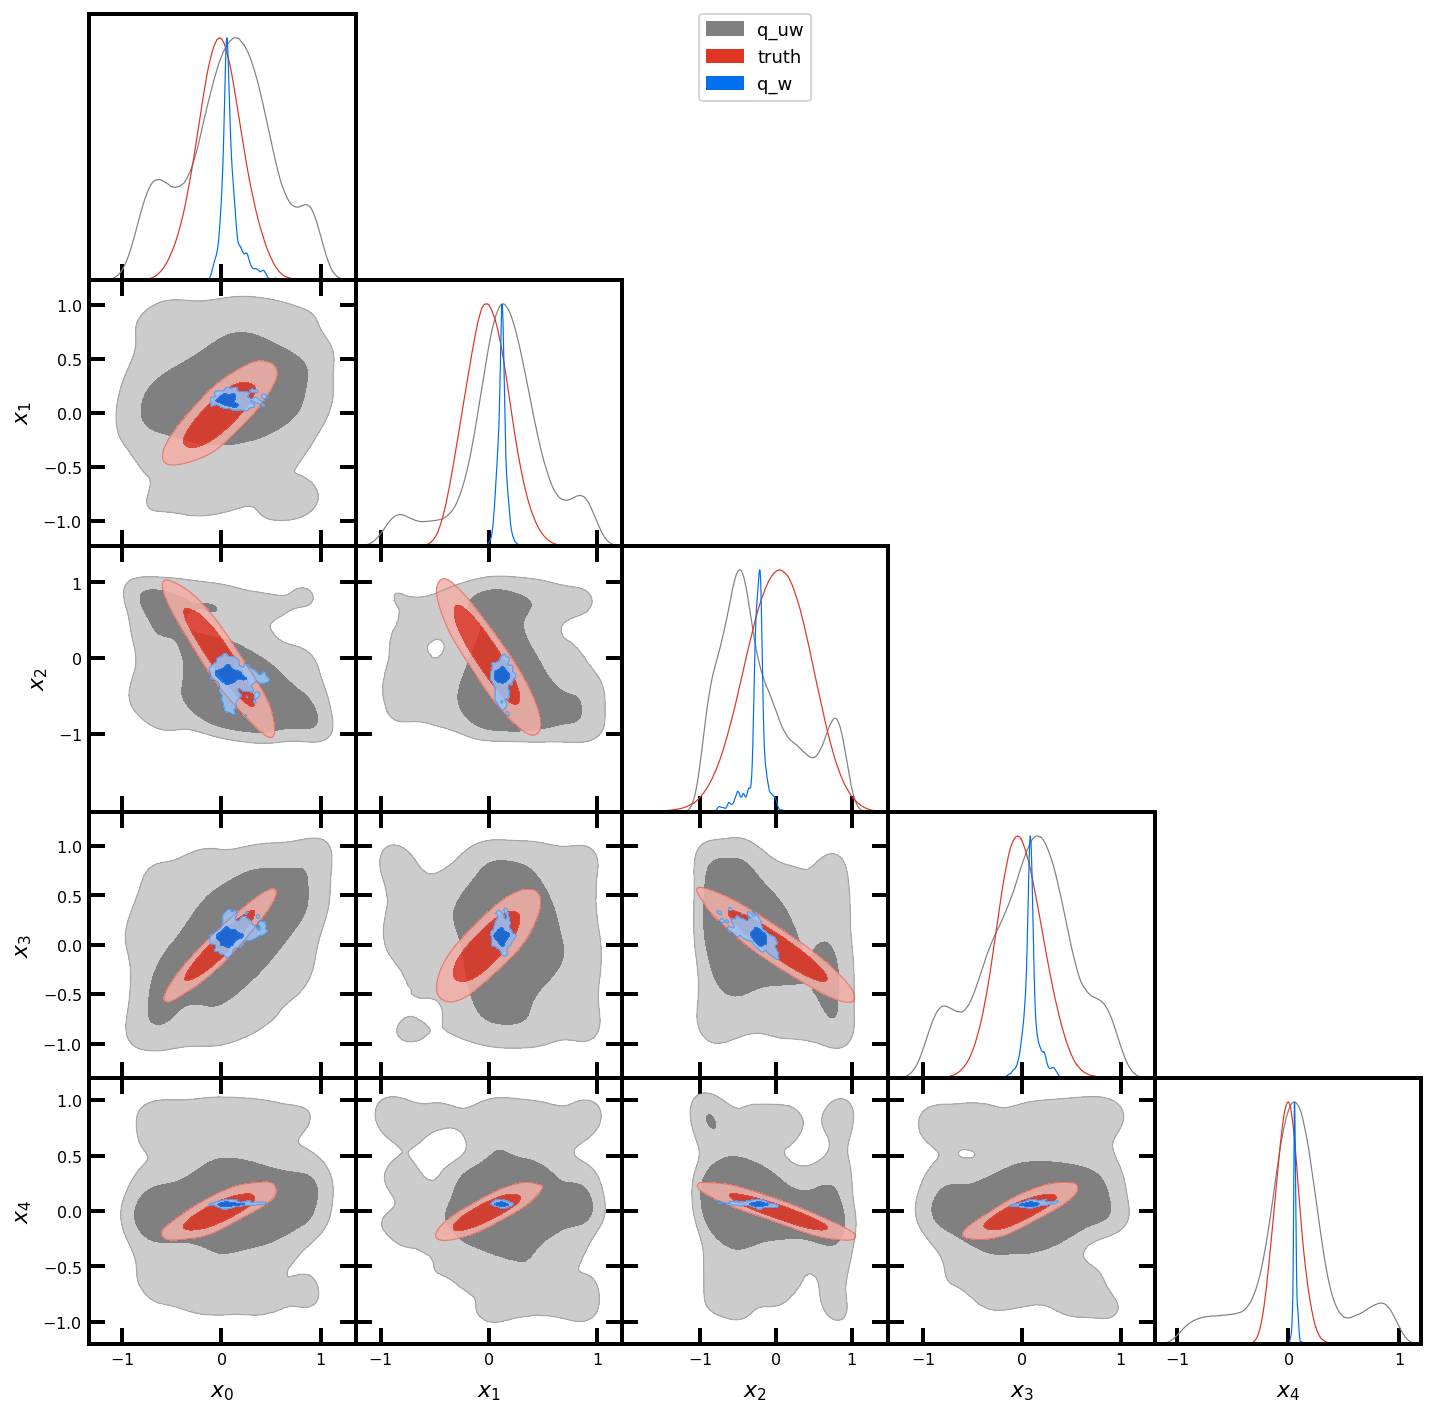

Removed no burn in
Removed no burn in
Removed no burn in


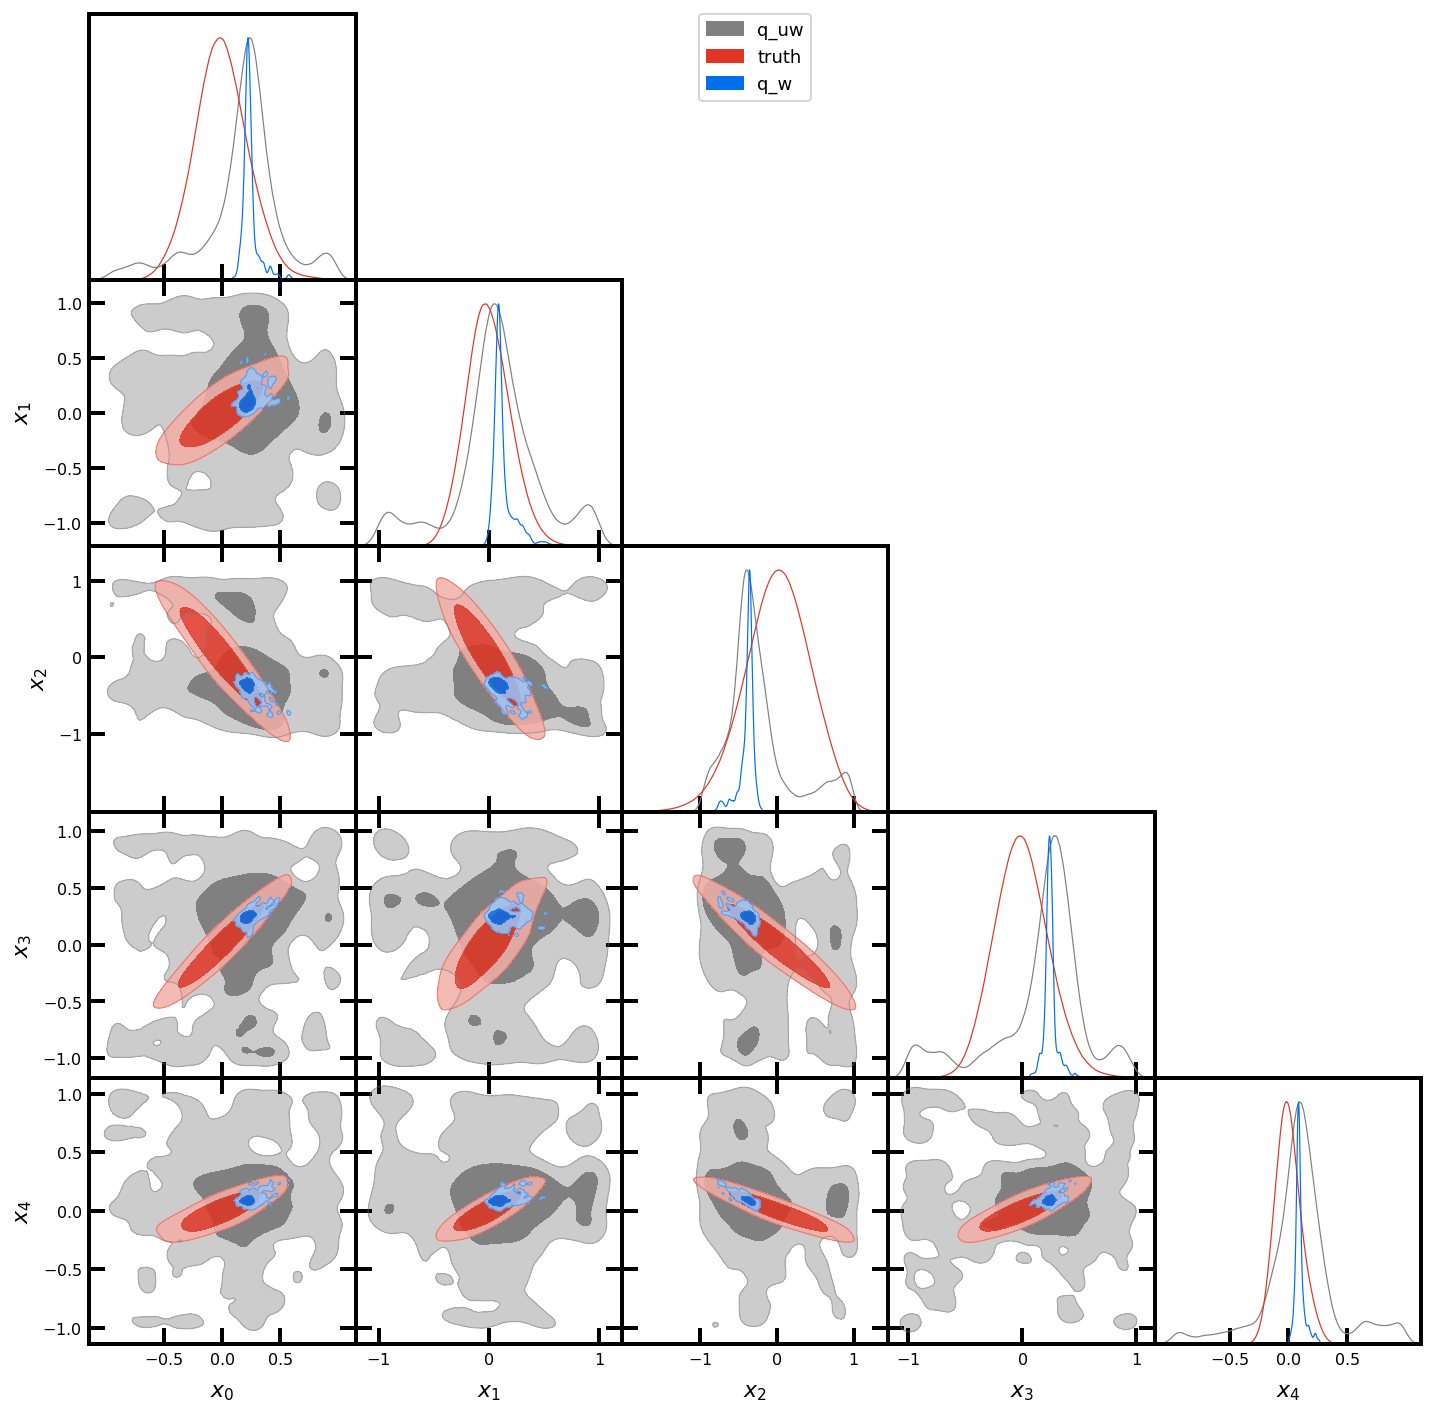

Removed no burn in
Removed no burn in
Removed no burn in


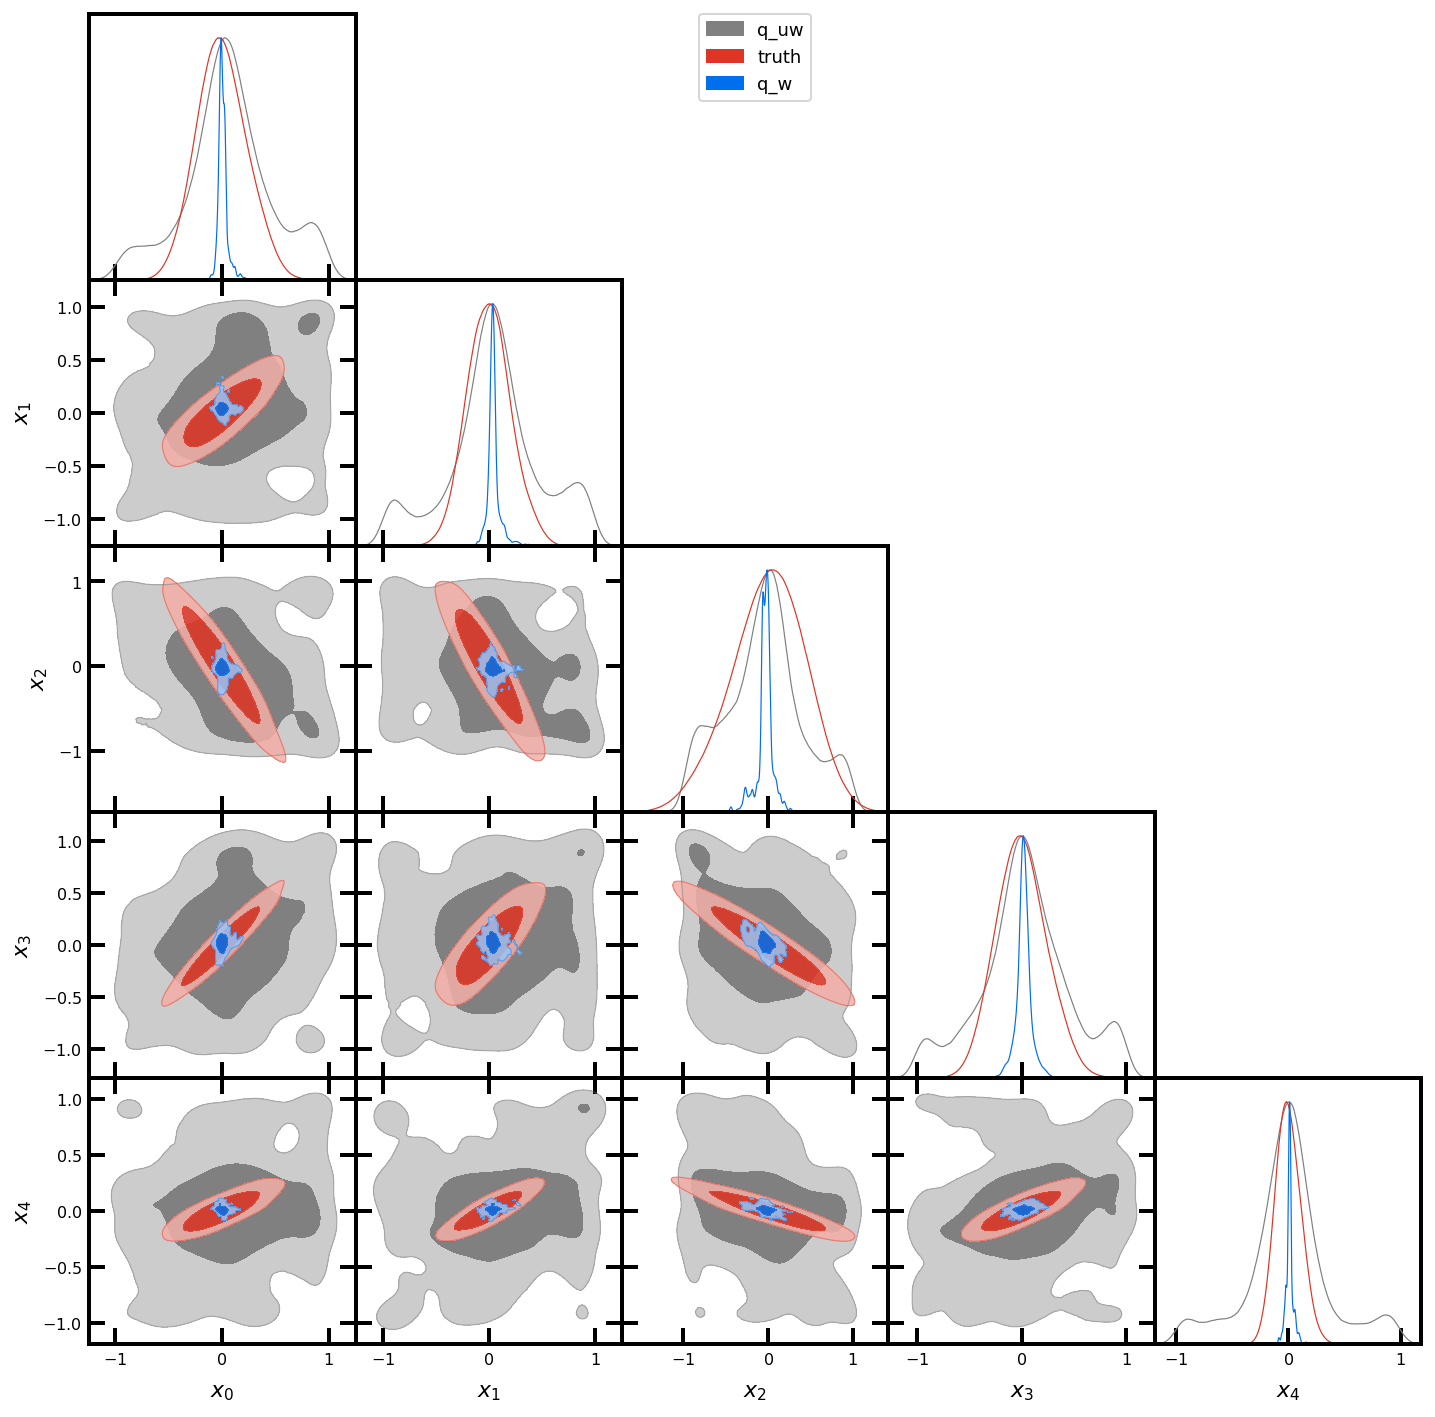

In [63]:
for t in ve: plot_corr_gd(t,Cov)

<hr style="border:2px solid gray"> </hr>

# Extra

## Changing X

In [10]:
xs,vx = [0.5,0.75,1.],[]
for x in xs: vx.append(run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,rel_beta=x))

Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5


Removed no burn in
Removed no burn in
Removed no burn in


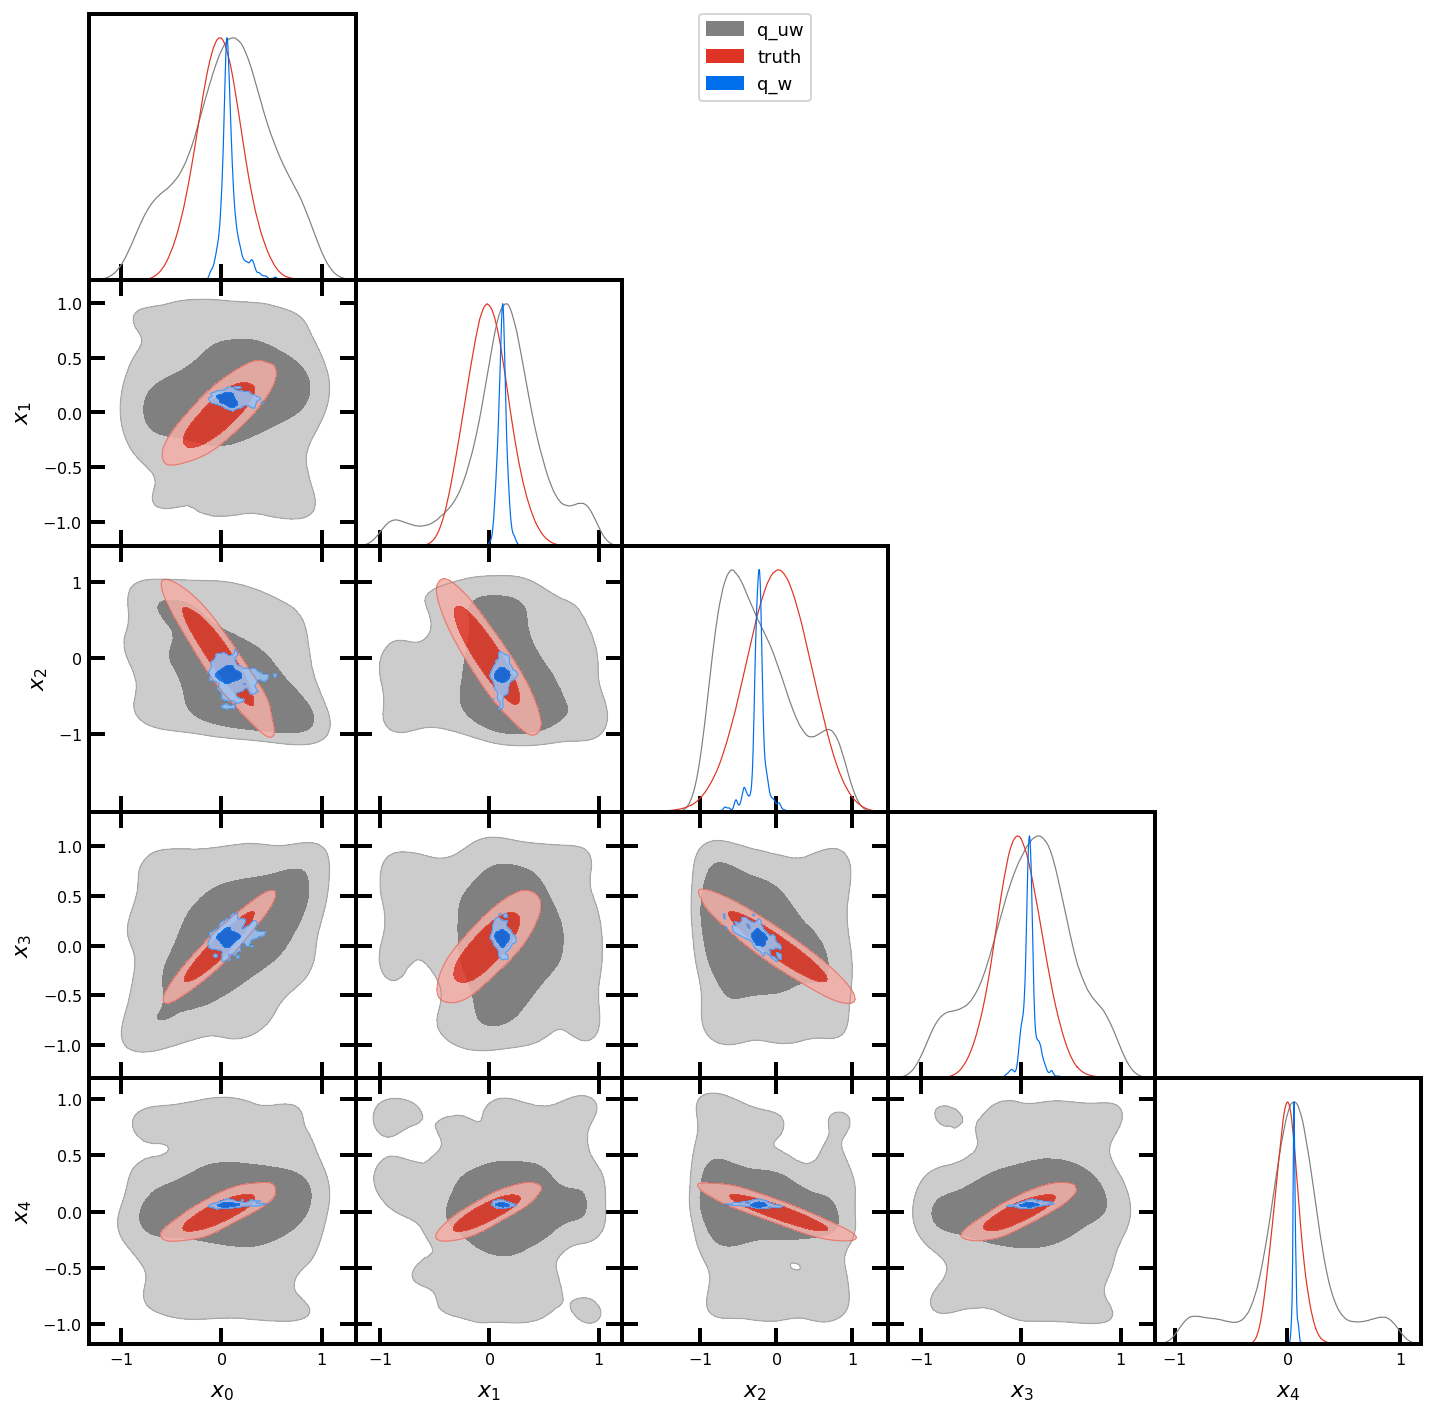

Removed no burn in
Removed no burn in
Removed no burn in


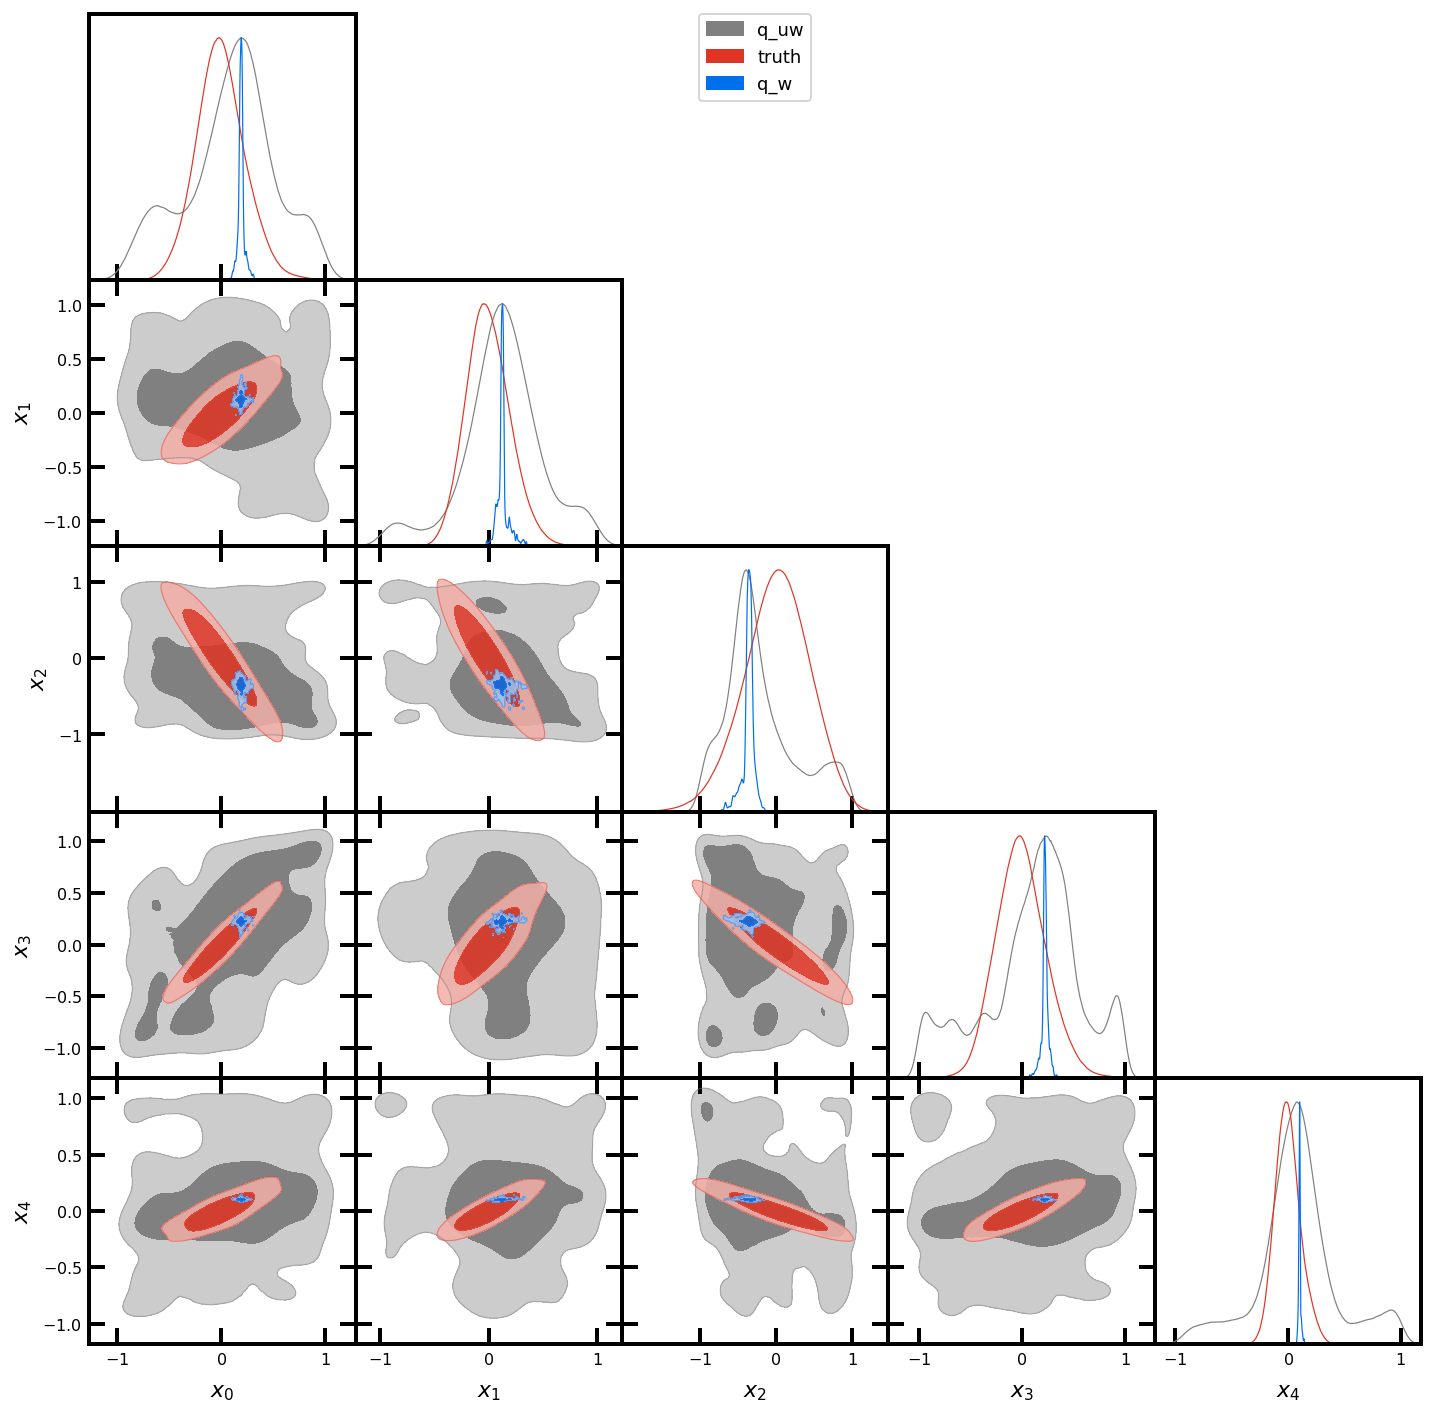

Removed no burn in
Removed no burn in
Removed no burn in


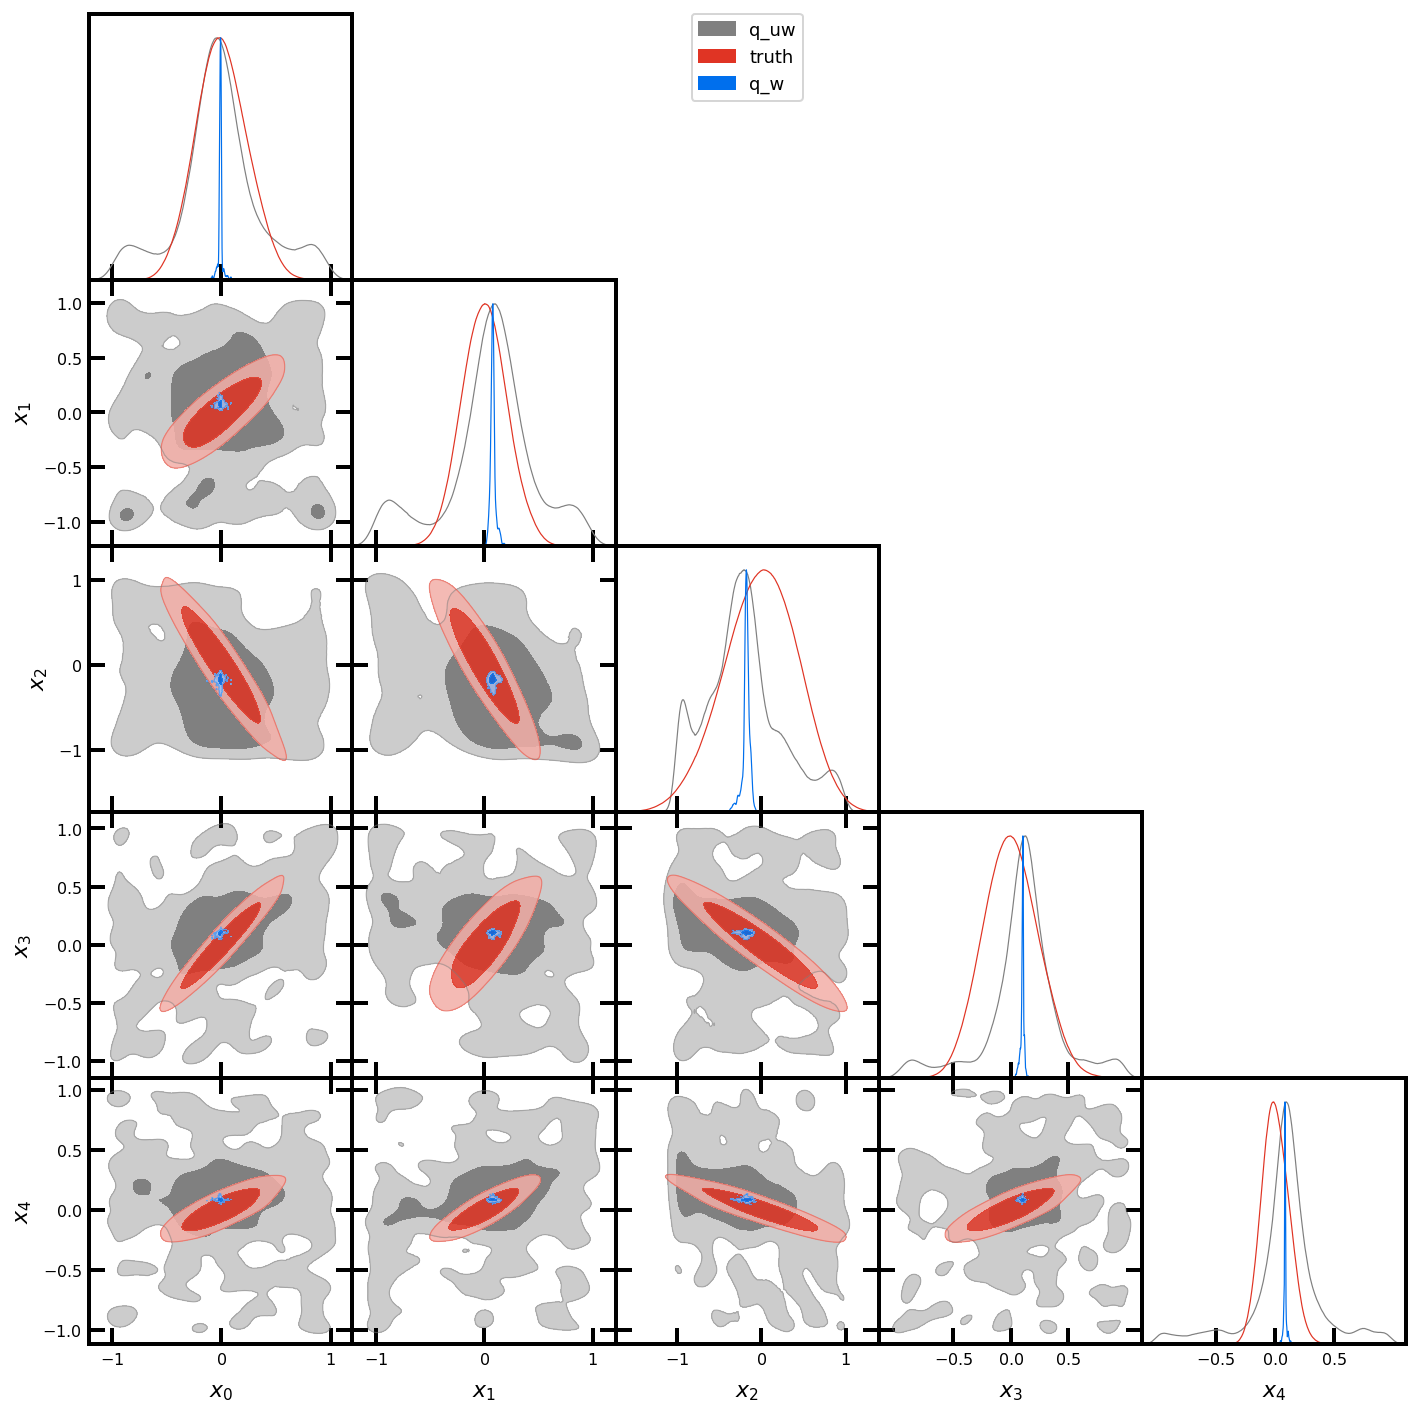

In [11]:
for t in vx: plot_corr_gd(t,Cov)

## Latent sampling through $q_{w}(\beta_{2})$ vs $q_{uw}$

In [12]:
beta_uw = [run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,use_latent_beta2=False),
run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,use_latent_beta2=True)]

Inference mode is optimization. Maximum beta is: 1.5
Inference mode is optimization. Maximum beta is: 1.5


Removed no burn in
Removed no burn in
Removed no burn in


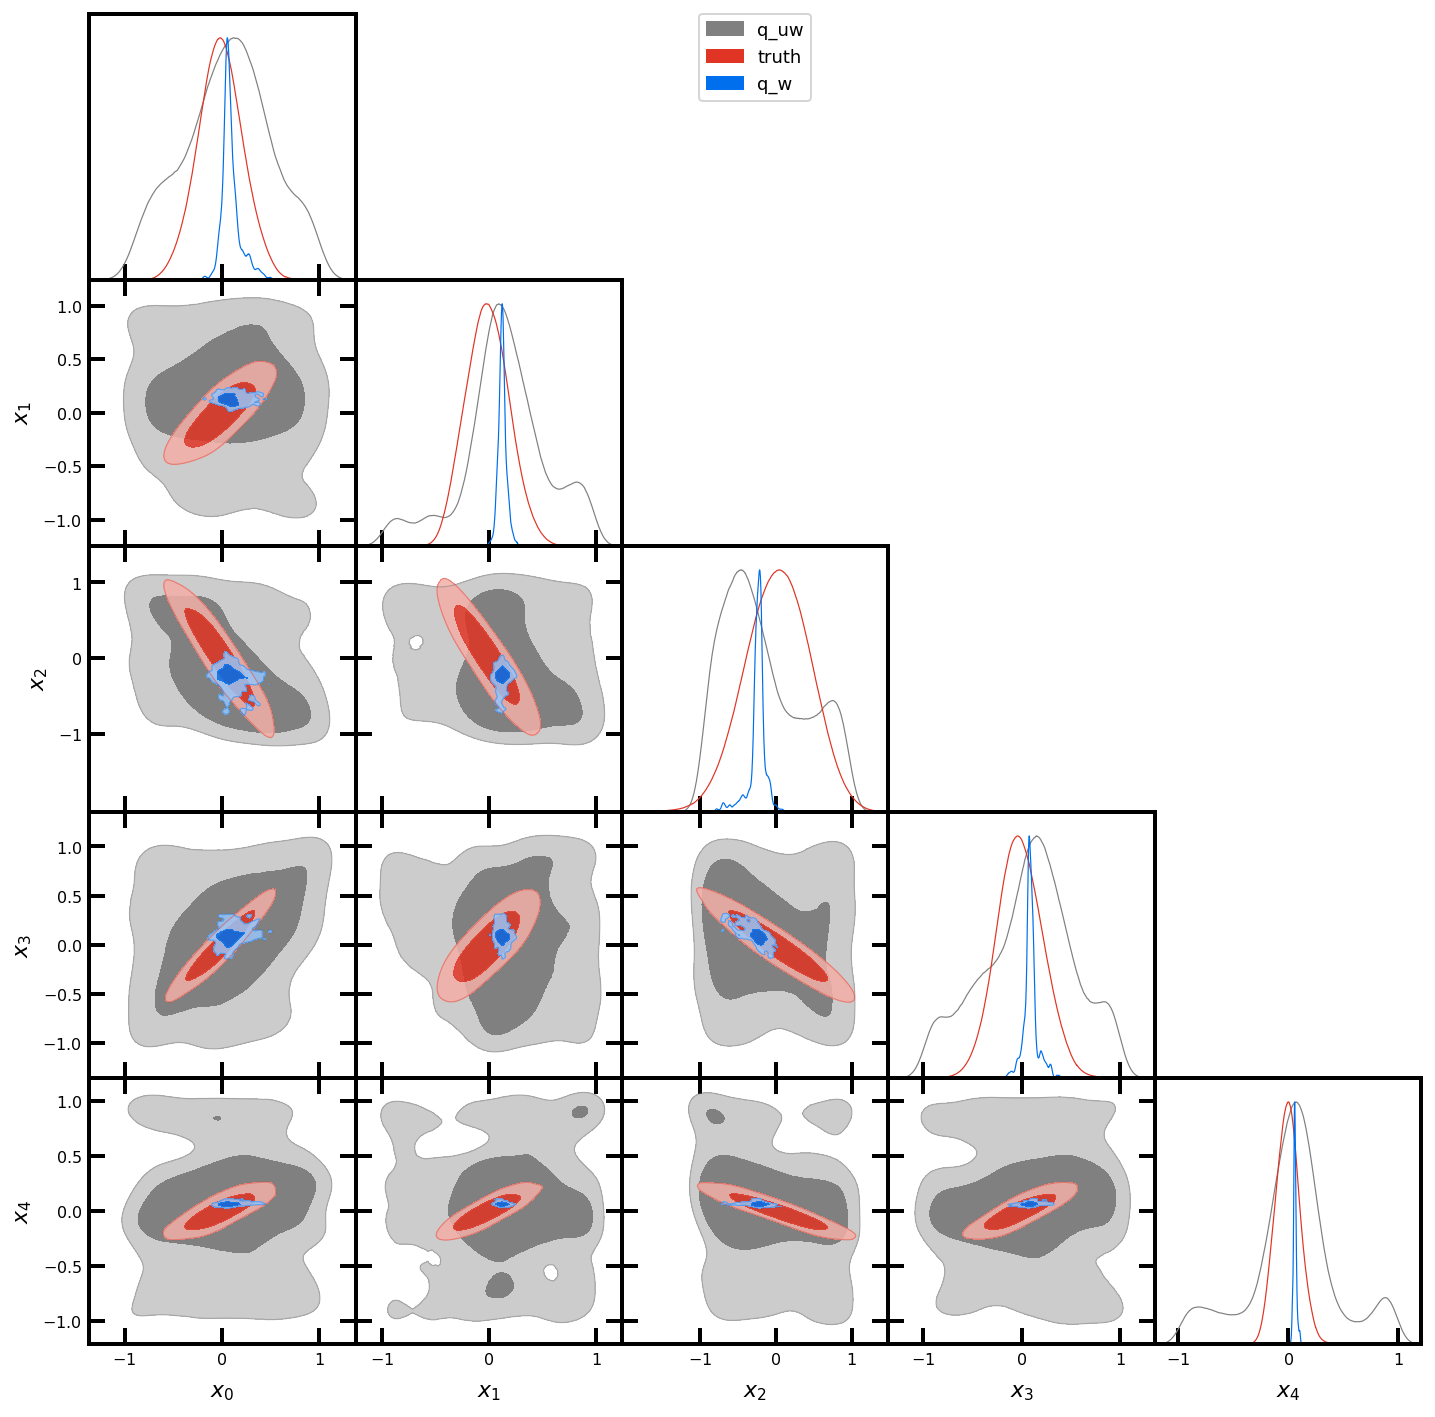

Removed no burn in
Removed no burn in
Removed no burn in


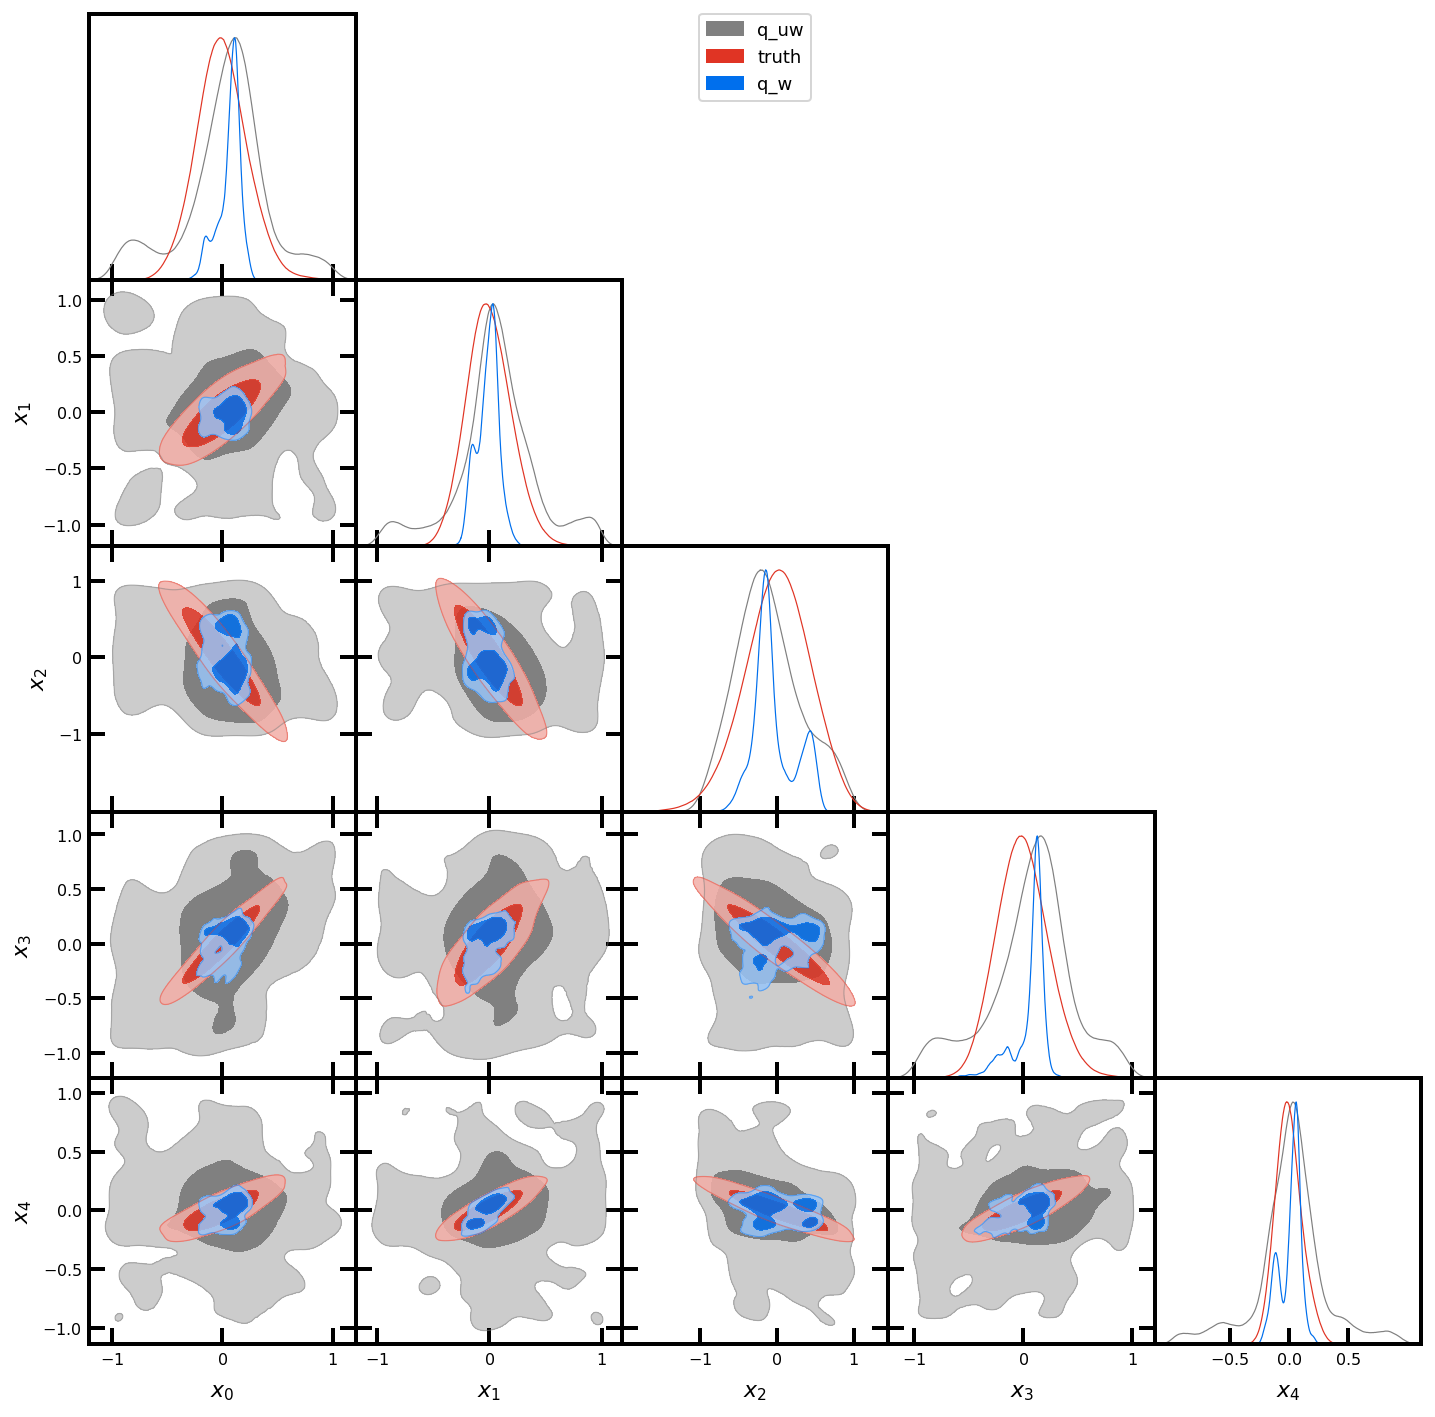

In [13]:
for t in beta_uw: plot_corr_gd(t,Cov)